In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [39]:
# load data
hummingbirds = pd.read_csv('../../../raw_inaturalist_exports/hummingbirds/observations-395877.csv')
bumblebees = pd.concat([
    pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396610.csv'),
    pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396616.csv')
])

dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')
red_validated = pd.read_csv('../../final_data/validated_FULL_gpt_labeled_REDS_ONLY.csv')

# remove "not red" species from `dat`
not_red_sp = red_validated[red_validated['validated'] == "no"]['binomial'].tolist()
dat.loc[dat['binomial'].isin(not_red_sp), 'color'] = 'nan'
dat = dat[dat['color'] != 'nan']

# add lon_window column based on longitude values
def categorize_longitude(lon):
    if -96 <= lon <= -59:
        return "Lon: -96 to -59"
    elif -130 <= lon < -96:
        return "Lon: -130 to -96"
    else:
        return np.nan

# apply to all 3
for df in [dat, hummingbirds, bumblebees]:
    df['lon_window'] = df['longitude'].apply(categorize_longitude)

# get "day_of_year" for all 3
for df in [dat, hummingbirds, bumblebees]:
    df['day_of_year'] = pd.to_datetime(df['observed_on'], errors='coerce').dt.dayofyear

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/1662797797.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396610.csv'),
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/1662797797.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../../raw_inaturalist_exports/bumblebees/observations-396616.csv')
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/1662797797.py:8: DtypeWarning: Columns (14,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/1662797797.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

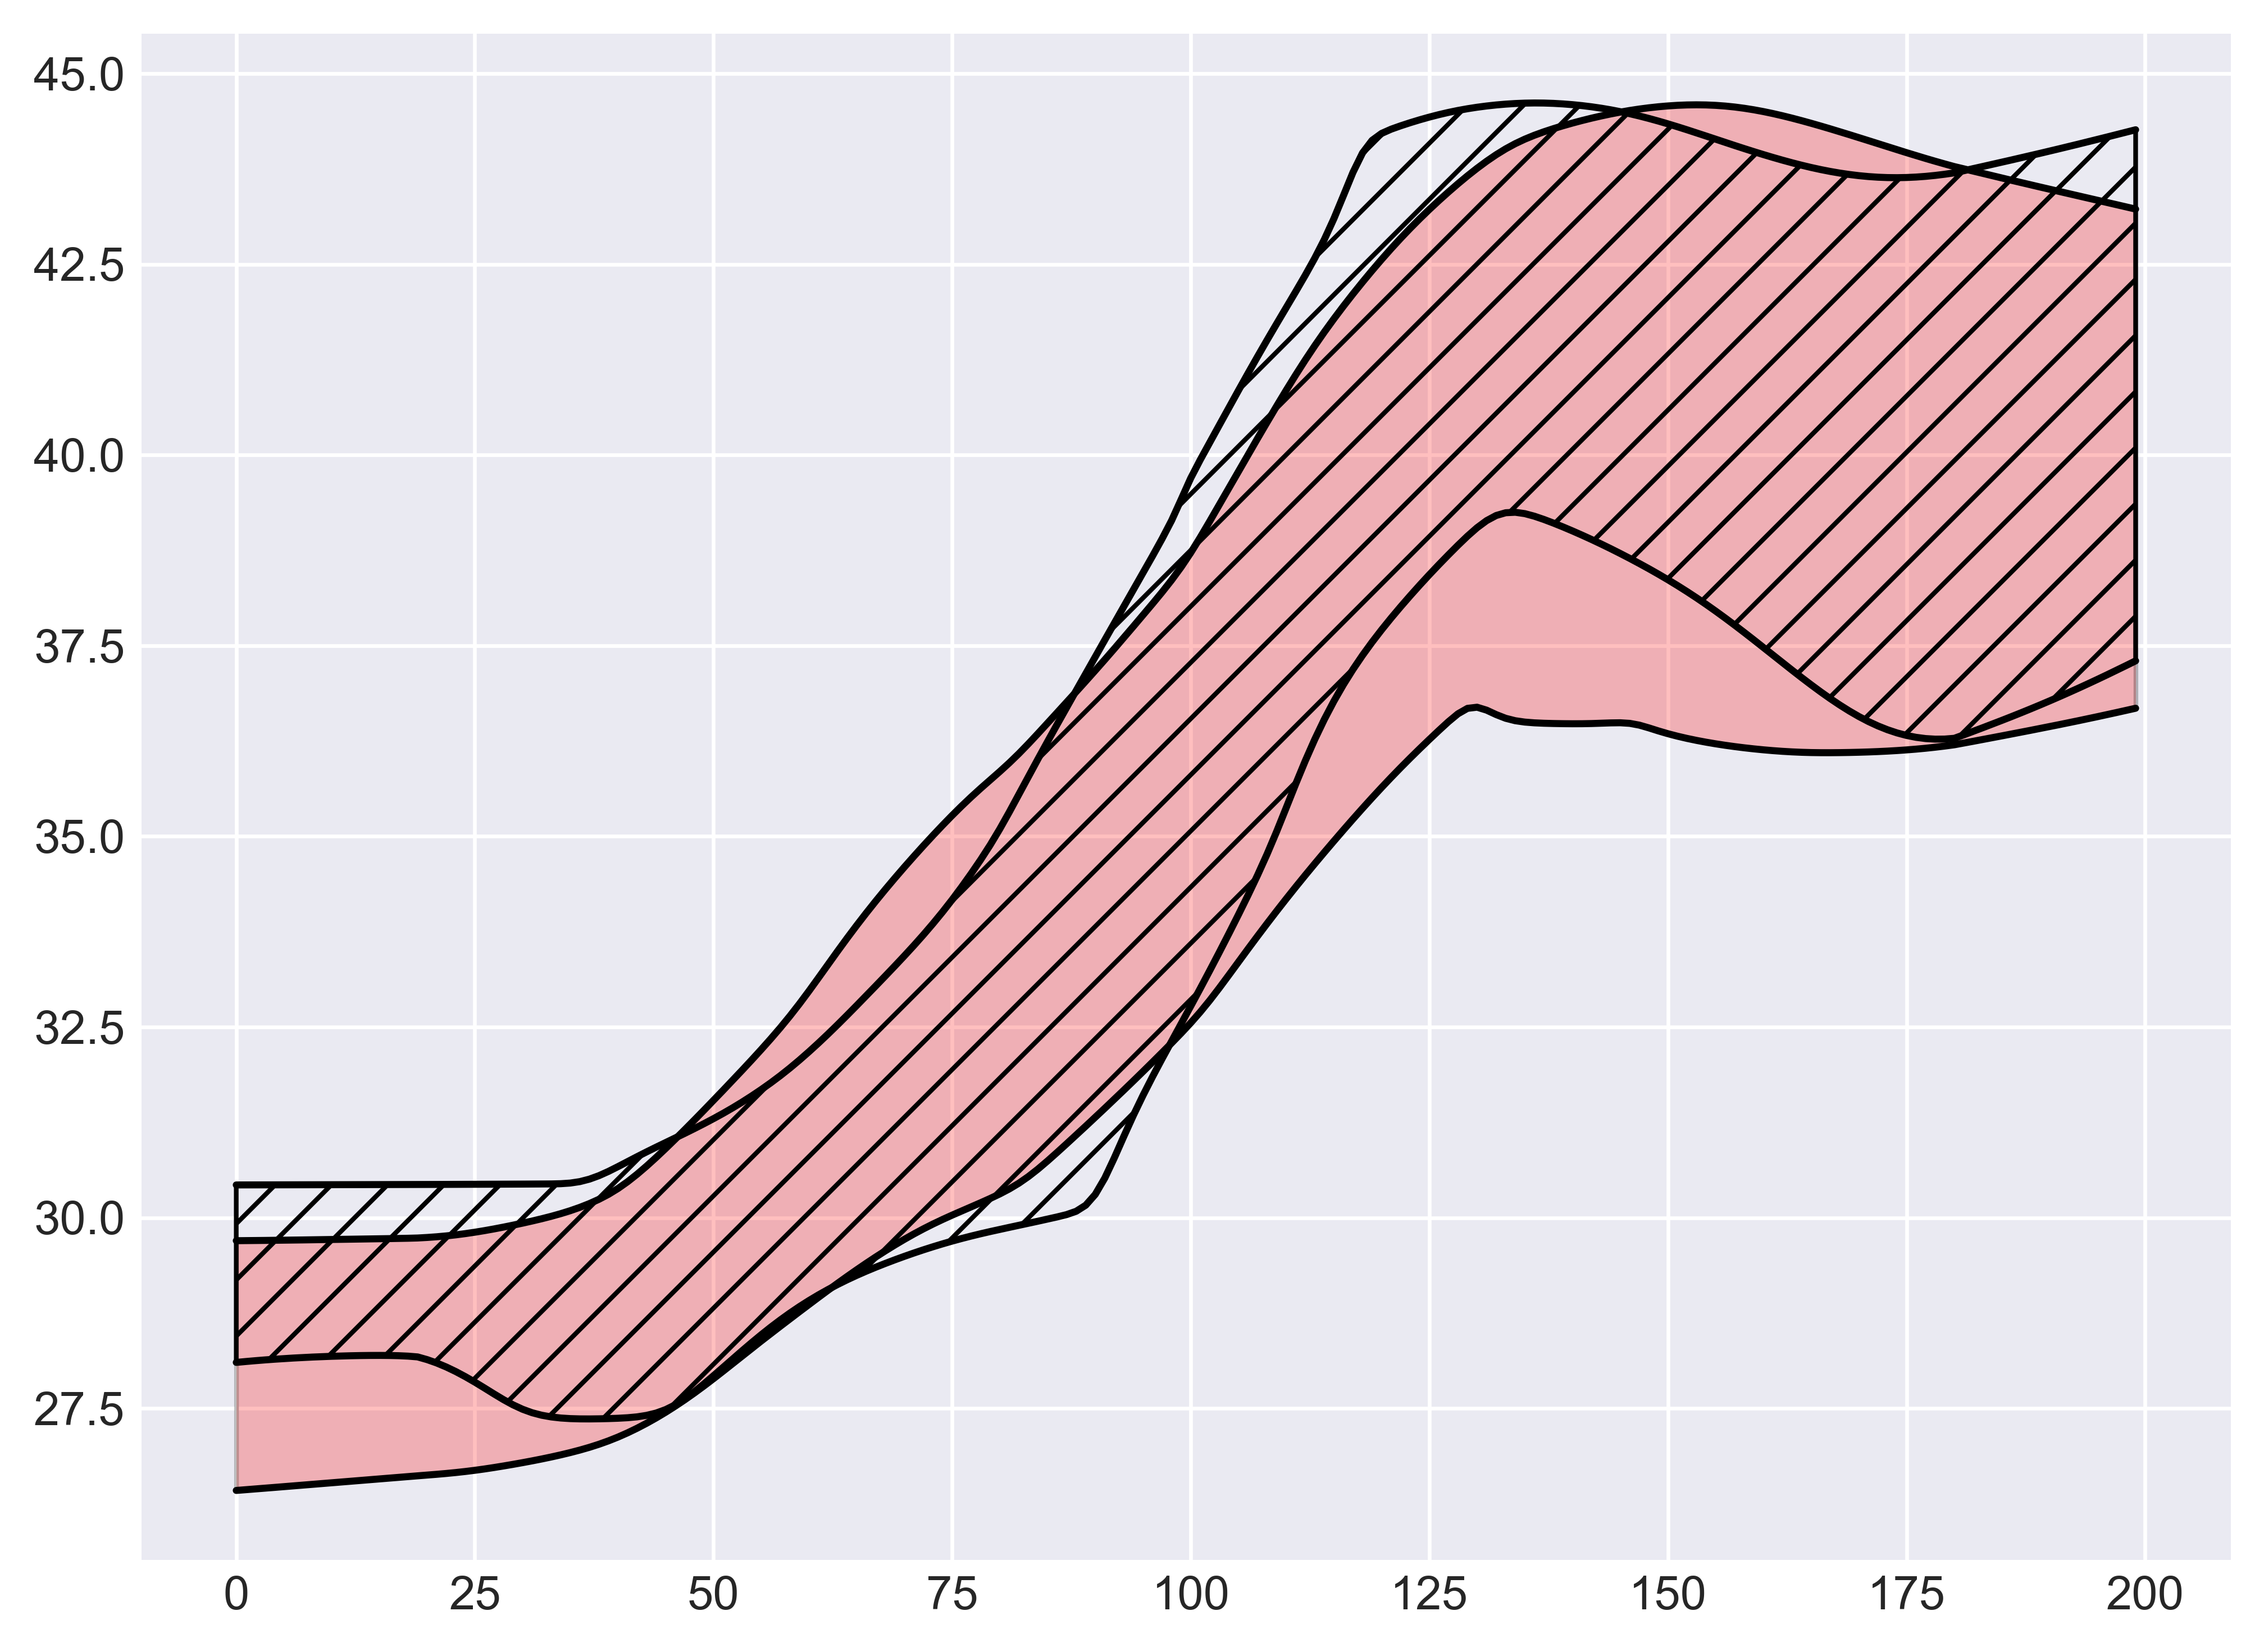

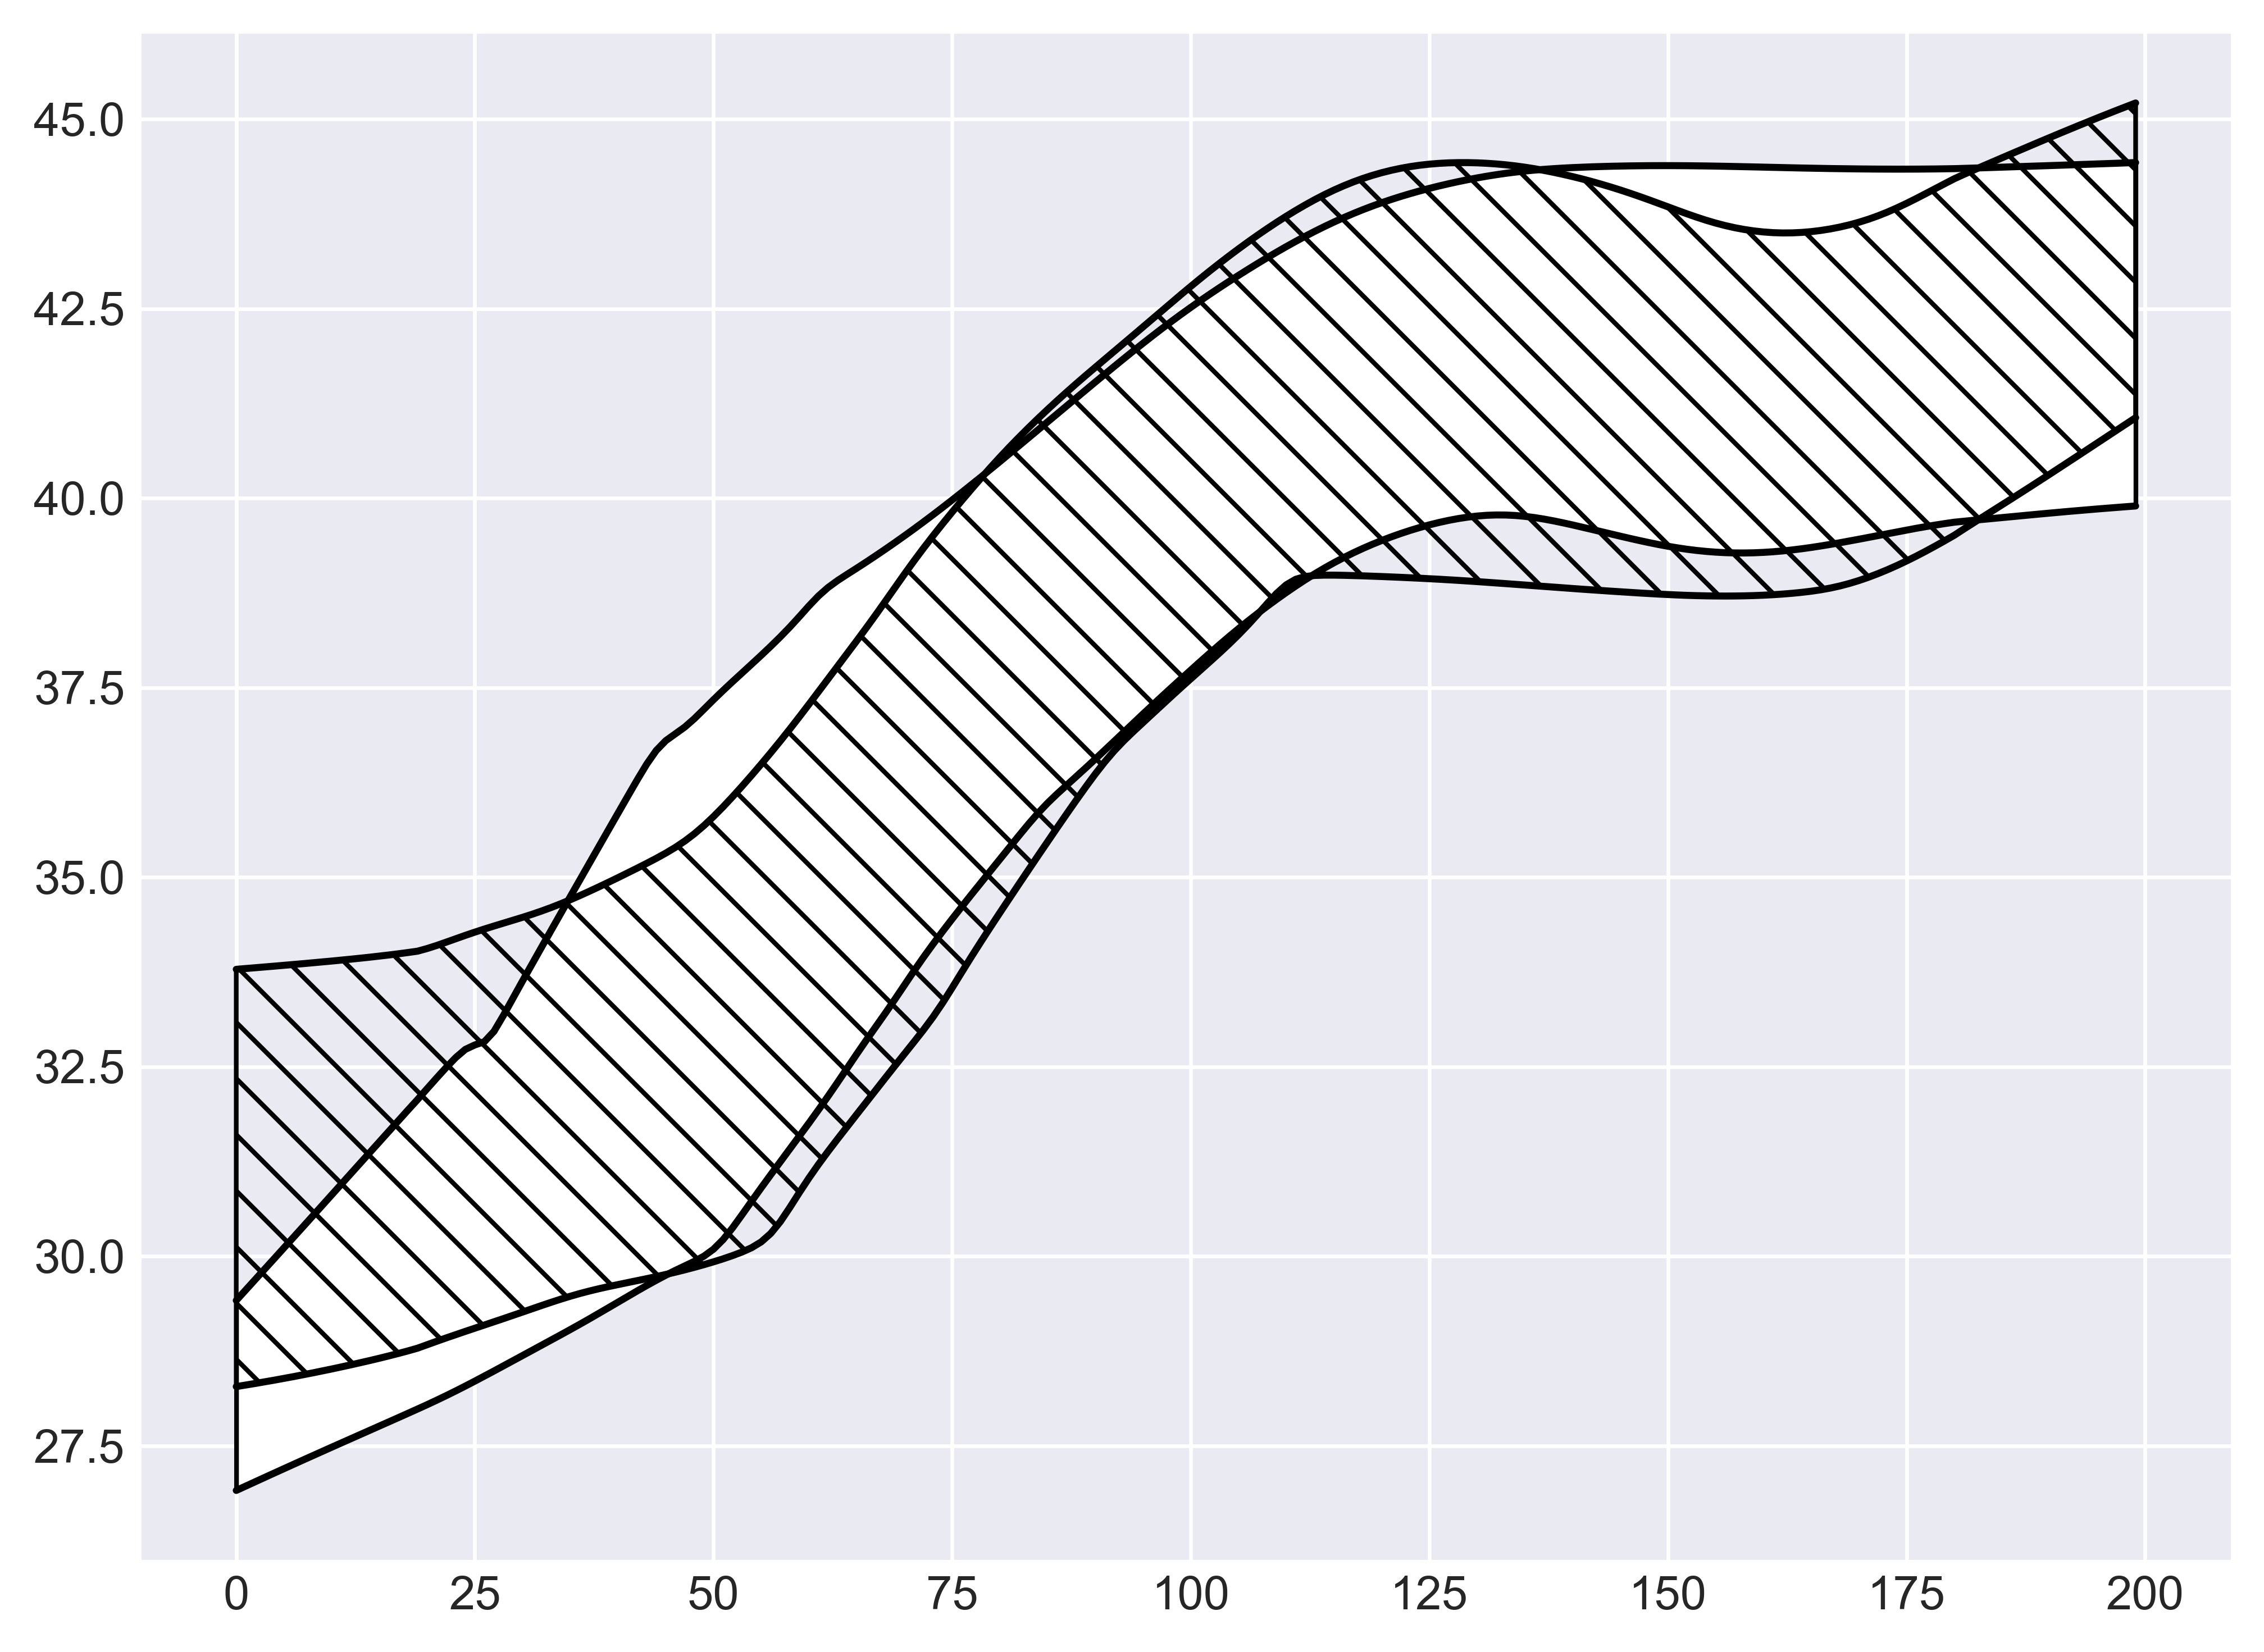

In [40]:
# constants
# mid 50 perc
percentile_threshold_upper = 0.75
percentile_threshold_lower = 0.25
# set window size
window_size = 30
max_days = 200  # capping to spring

# init df
quantile_dat = pd.DataFrame(index=range(365 - window_size), columns=["red_upper", "red_lower", "white_upper", "white_lower", "hummers_upper", "hummers_lower", "bombus_upper", "bombus_lower"])

# get quantiles for red and white flowers in each window
for loopcolor in ['red', 'white']:
    subdf = dat[(dat['color'] == loopcolor) & (dat['lon_window'] == "Lon: -96 to -59")]
    
    if len(subdf) > 0:
        for day in range(365 - window_size): # doing all year for now, capping later
            day_range = list(range(day, day + window_size))
            window_df = subdf[subdf['day_of_year'].isin(day_range)]
            
            if len(window_df) > 0:
                upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
                lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
                
                quantile_dat.loc[day, f"{loopcolor}_upper"] = upper_val
                quantile_dat.loc[day, f"{loopcolor}_lower"] = lower_val

# hummingbird quantiles
hummers_subdf = hummingbirds[hummingbirds['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = hummers_subdf[hummers_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "hummers_upper"] = upper_val
        quantile_dat.loc[day, "hummers_lower"] = lower_val

# bumblebee quantiles
bombus_subdf = bumblebees[bumblebees['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = bombus_subdf[bombus_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "bombus_upper"] = upper_val
        quantile_dat.loc[day, "bombus_lower"] = lower_val

# numeric columns
quantile_dat = quantile_dat.apply(pd.to_numeric, errors='coerce')

# backfill na vals if present
quantile_dat = quantile_dat.fillna(method='bfill')

# grey background
plt.style.use('seaborn-darkgrid')

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### Red flowers vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat['red_lower'][:max_days], quantile_dat['red_upper'][:max_days], 'red', 'Red Flowers', 0.25)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')


# save and show
plt.savefig('../hummers_red.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### White flowers vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat['white_lower'][:max_days], quantile_dat['white_upper'][:max_days], 'white', 'White Flowers', 1.0)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')

# save and show
#plt.savefig('../bombus_white.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### Blue

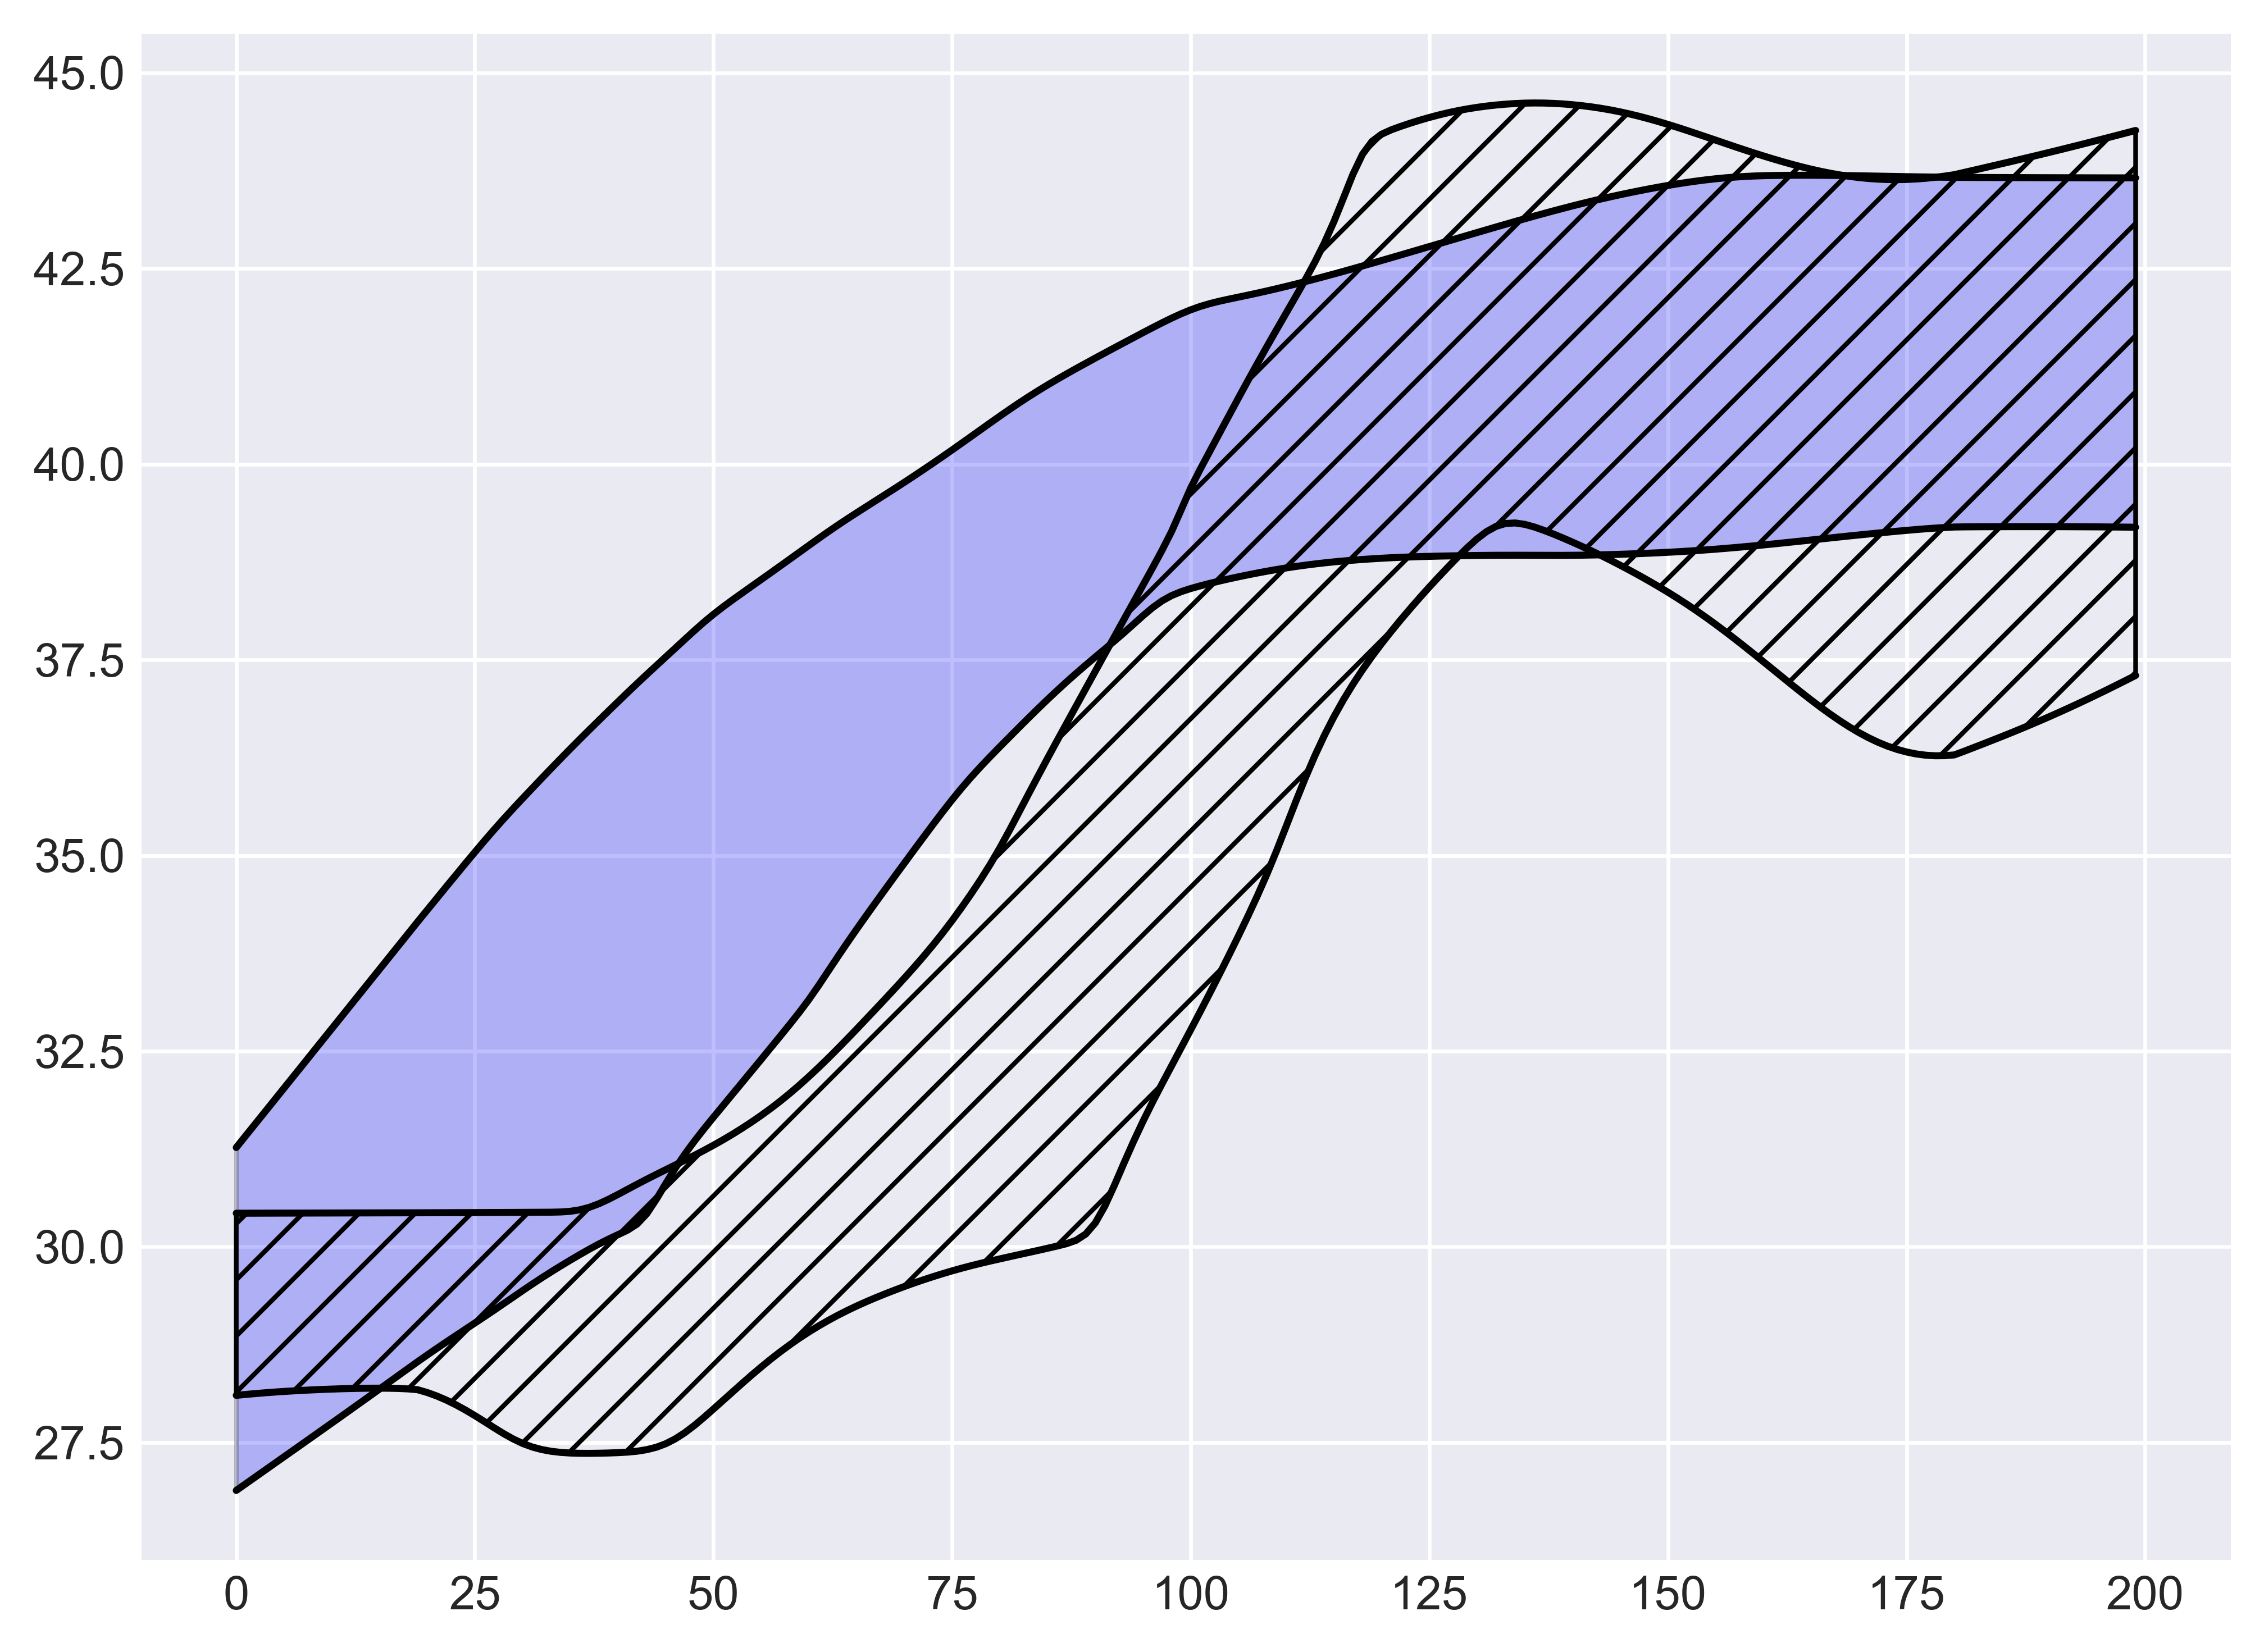

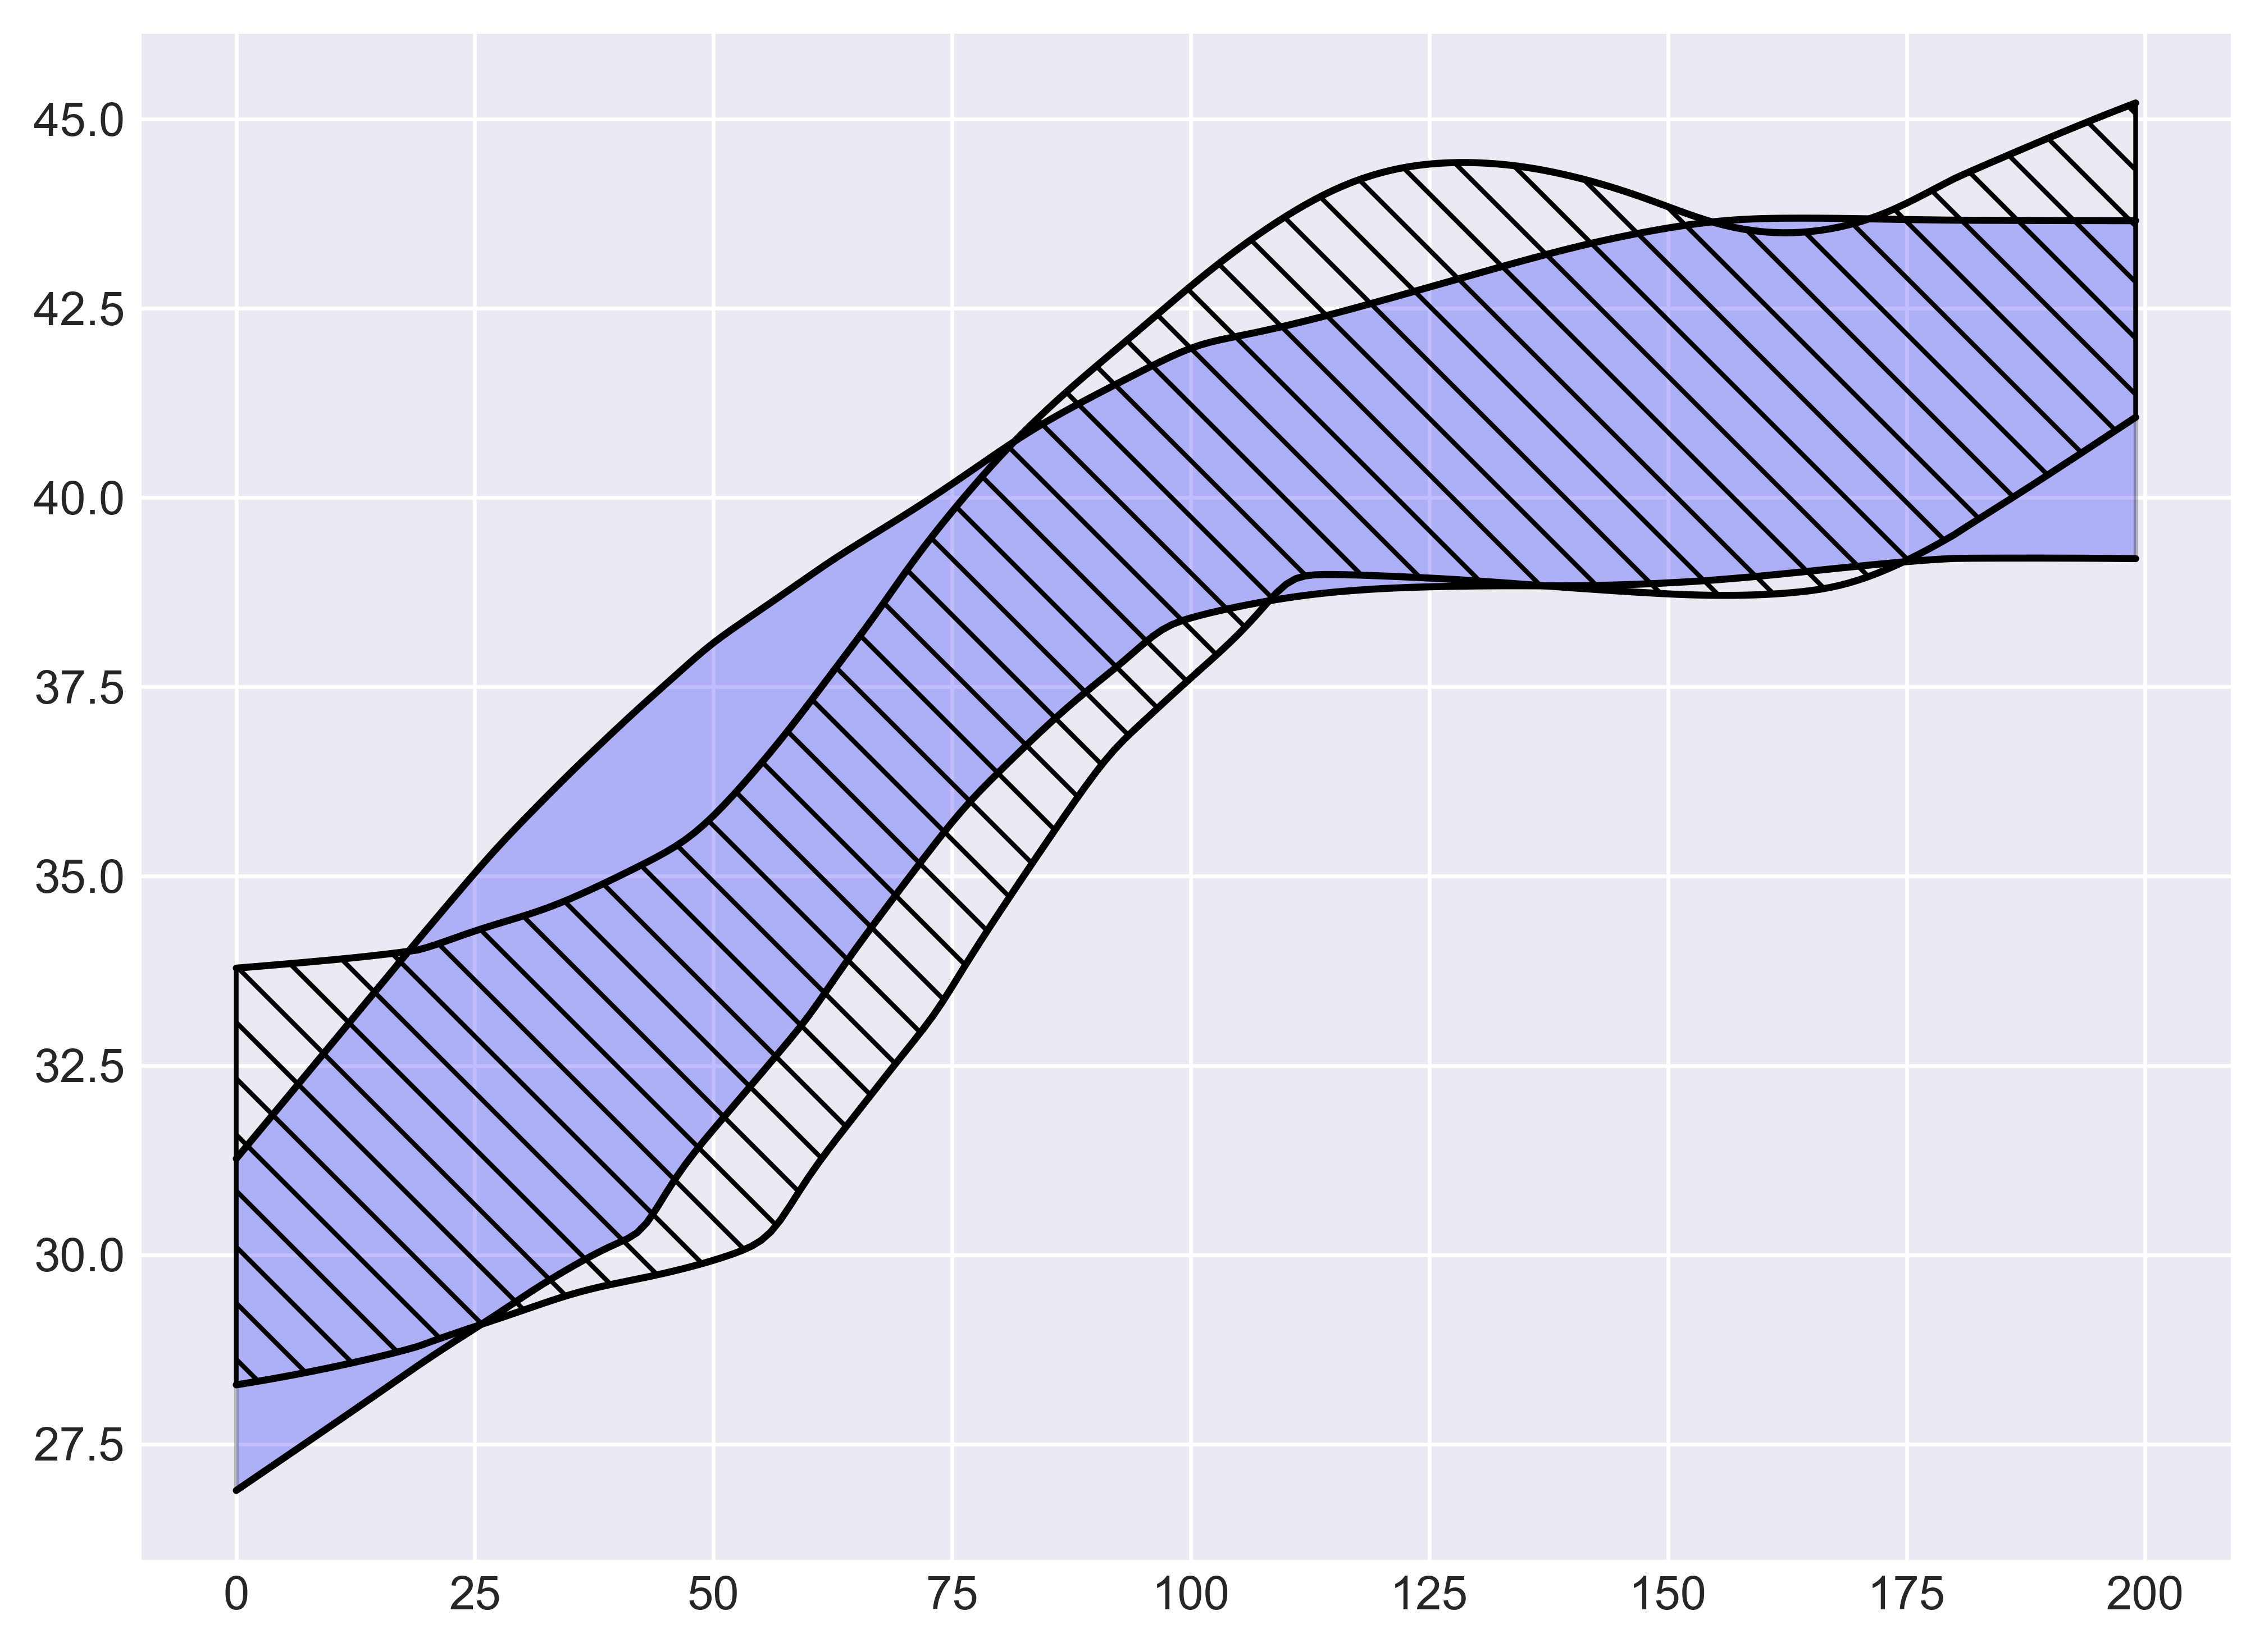

In [41]:
comparecolor = "blue"

# constants
# mid 50 perc
percentile_threshold_upper = 0.75
percentile_threshold_lower = 0.25
# set window size
window_size = 30
max_days = 200  # capping to spring

# init df
quantile_dat = pd.DataFrame(index=range(365 - window_size), columns=["red_upper", "red_lower", f"{comparecolor}_upper", f"{comparecolor}_lower", "hummers_upper", "hummers_lower", "bombus_upper", "bombus_lower"])

# get quantiles in each window
subdf = dat[(dat['color'] == comparecolor) & (dat['lon_window'] == "Lon: -96 to -59")]

if len(subdf) > 0:
    for day in range(365 - window_size): # doing all year for now, capping later
        day_range = list(range(day, day + window_size))
        window_df = subdf[subdf['day_of_year'].isin(day_range)]

        if len(window_df) > 0:
            upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
            lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)

            quantile_dat.loc[day, f"{comparecolor}_upper"] = upper_val
            quantile_dat.loc[day, f"{comparecolor}_lower"] = lower_val

# hummingbird quantiles
hummers_subdf = hummingbirds[hummingbirds['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = hummers_subdf[hummers_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "hummers_upper"] = upper_val
        quantile_dat.loc[day, "hummers_lower"] = lower_val

# bumblebee quantiles
bombus_subdf = bumblebees[bumblebees['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = bombus_subdf[bombus_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "bombus_upper"] = upper_val
        quantile_dat.loc[day, "bombus_lower"] = lower_val

# numeric columns
quantile_dat = quantile_dat.apply(pd.to_numeric, errors='coerce')

# backfill na vals if present
quantile_dat = quantile_dat.fillna(method='bfill')

# grey background
plt.style.use('seaborn-darkgrid')

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], comparecolor, f'{comparecolor} Flowers', 0.25)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')


# save and show
plt.savefig('../bluehumm.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], comparecolor, f'{comparecolor} Flowers', .25)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')

# save and show
plt.savefig('../bluebombus.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

## Yellow

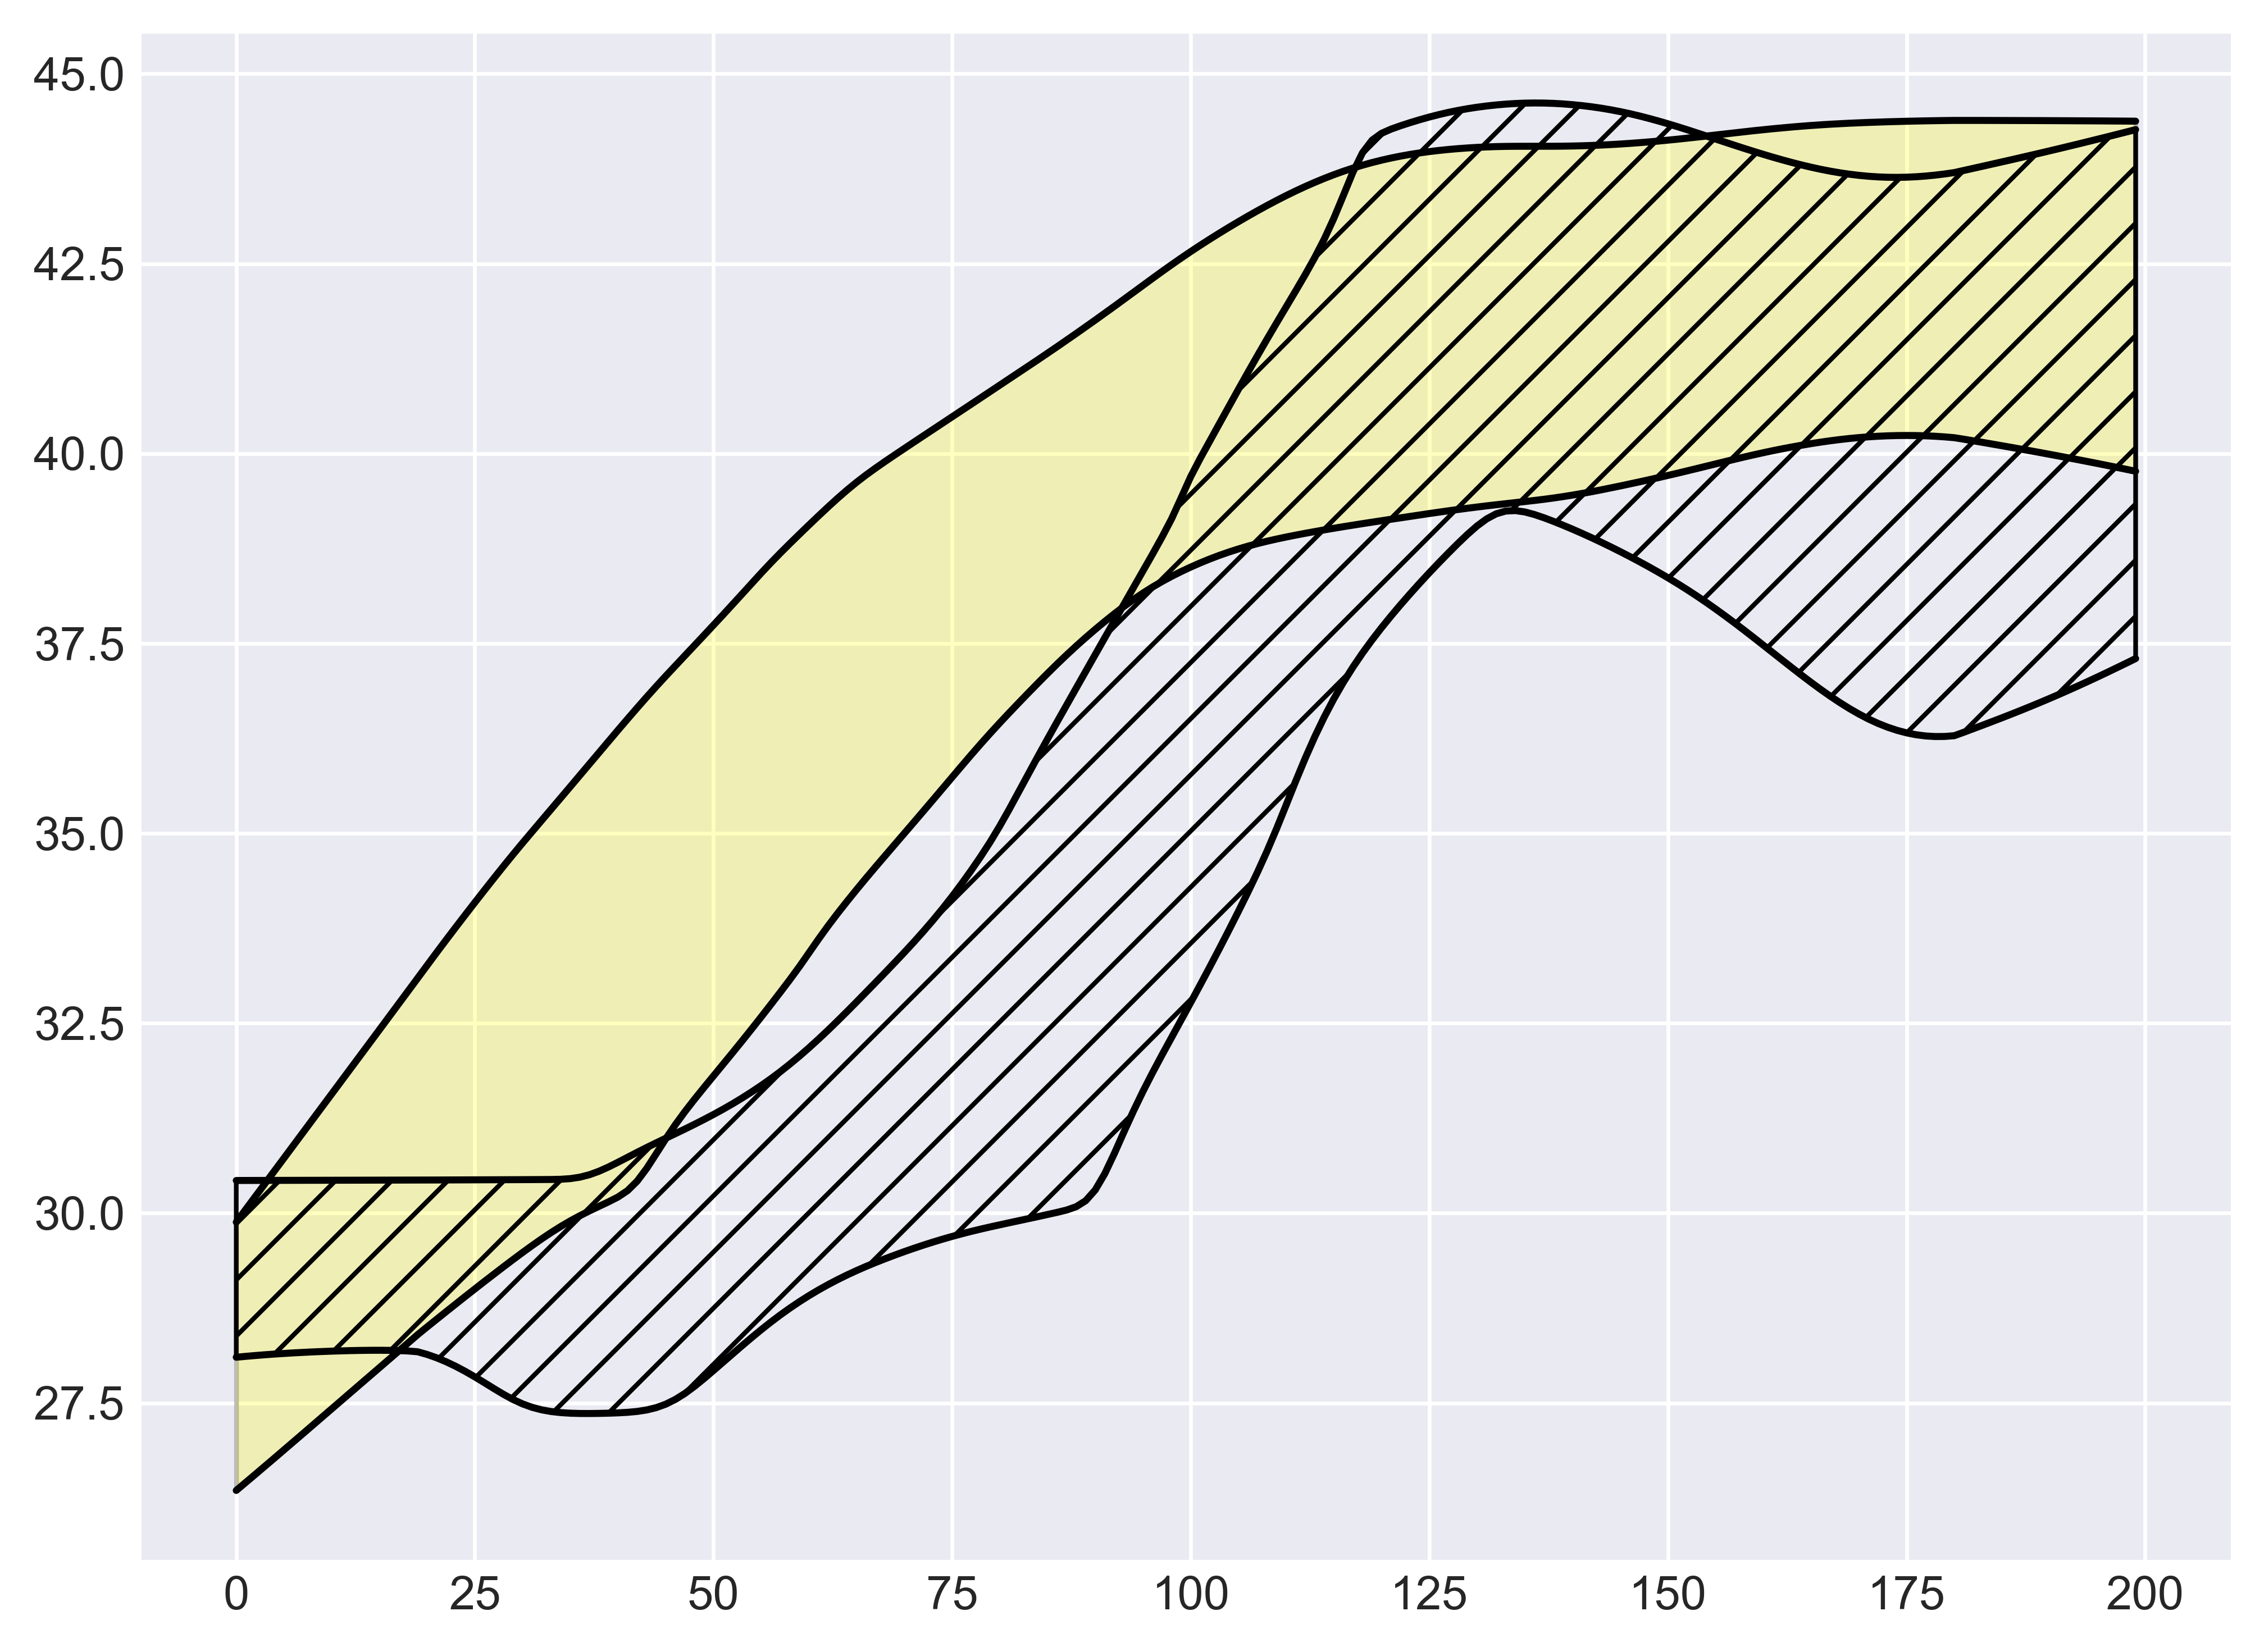

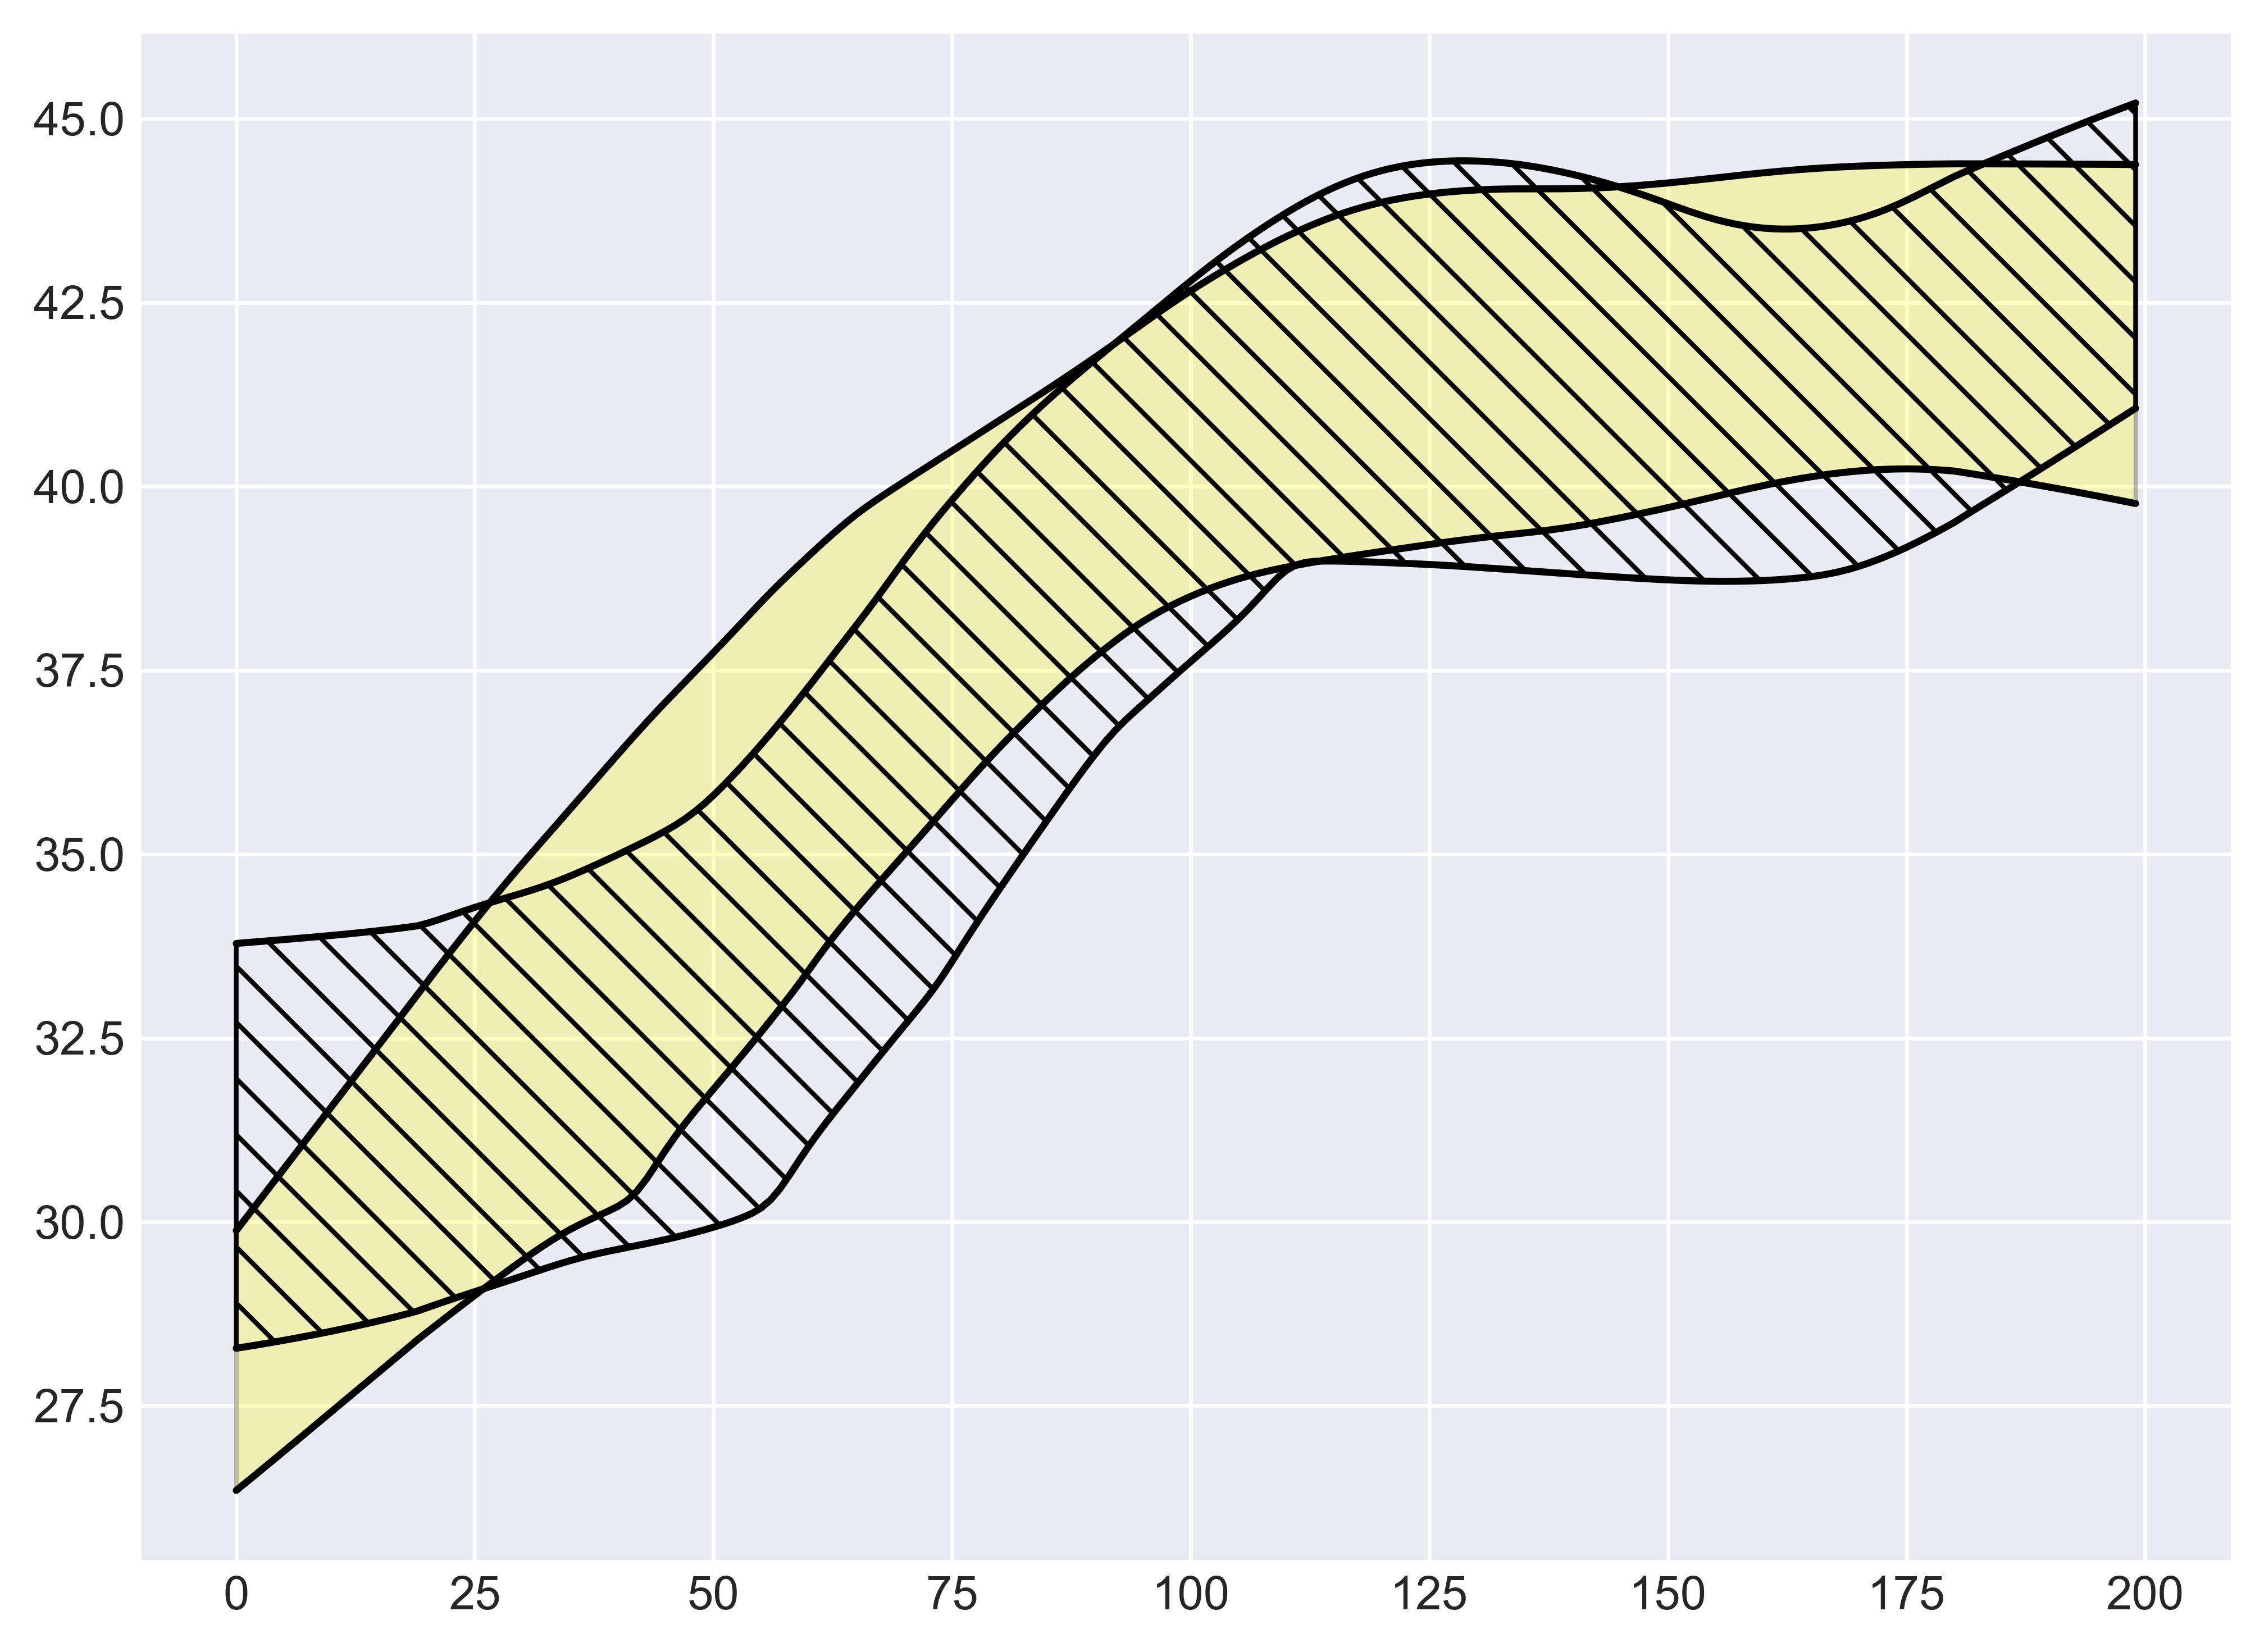

In [42]:
comparecolor = "yellow"

# constants
# mid 50 perc
percentile_threshold_upper = 0.75
percentile_threshold_lower = 0.25
# set window size
window_size = 30
max_days = 200  # capping to spring

# init df
quantile_dat = pd.DataFrame(index=range(365 - window_size), columns=["red_upper", "red_lower", f"{comparecolor}_upper", f"{comparecolor}_lower", "hummers_upper", "hummers_lower", "bombus_upper", "bombus_lower"])

# get quantiles in each window
subdf = dat[(dat['color'] == comparecolor) & (dat['lon_window'] == "Lon: -96 to -59")]

if len(subdf) > 0:
    for day in range(365 - window_size): # doing all year for now, capping later
        day_range = list(range(day, day + window_size))
        window_df = subdf[subdf['day_of_year'].isin(day_range)]

        if len(window_df) > 0:
            upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
            lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)

            quantile_dat.loc[day, f"{comparecolor}_upper"] = upper_val
            quantile_dat.loc[day, f"{comparecolor}_lower"] = lower_val

# hummingbird quantiles
hummers_subdf = hummingbirds[hummingbirds['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = hummers_subdf[hummers_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "hummers_upper"] = upper_val
        quantile_dat.loc[day, "hummers_lower"] = lower_val

# bumblebee quantiles
bombus_subdf = bumblebees[bumblebees['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = bombus_subdf[bombus_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "bombus_upper"] = upper_val
        quantile_dat.loc[day, "bombus_lower"] = lower_val

# numeric columns
quantile_dat = quantile_dat.apply(pd.to_numeric, errors='coerce')

# backfill na vals if present
quantile_dat = quantile_dat.fillna(method='bfill')

# grey background
plt.style.use('seaborn-darkgrid')

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], comparecolor, f'{comparecolor} Flowers', 0.25)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')


# save and show
plt.savefig('../yellowhumm.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], comparecolor, f'{comparecolor} Flowers', .25)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')

# save and show
plt.savefig('../yellowbombus.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

## Pink/purple

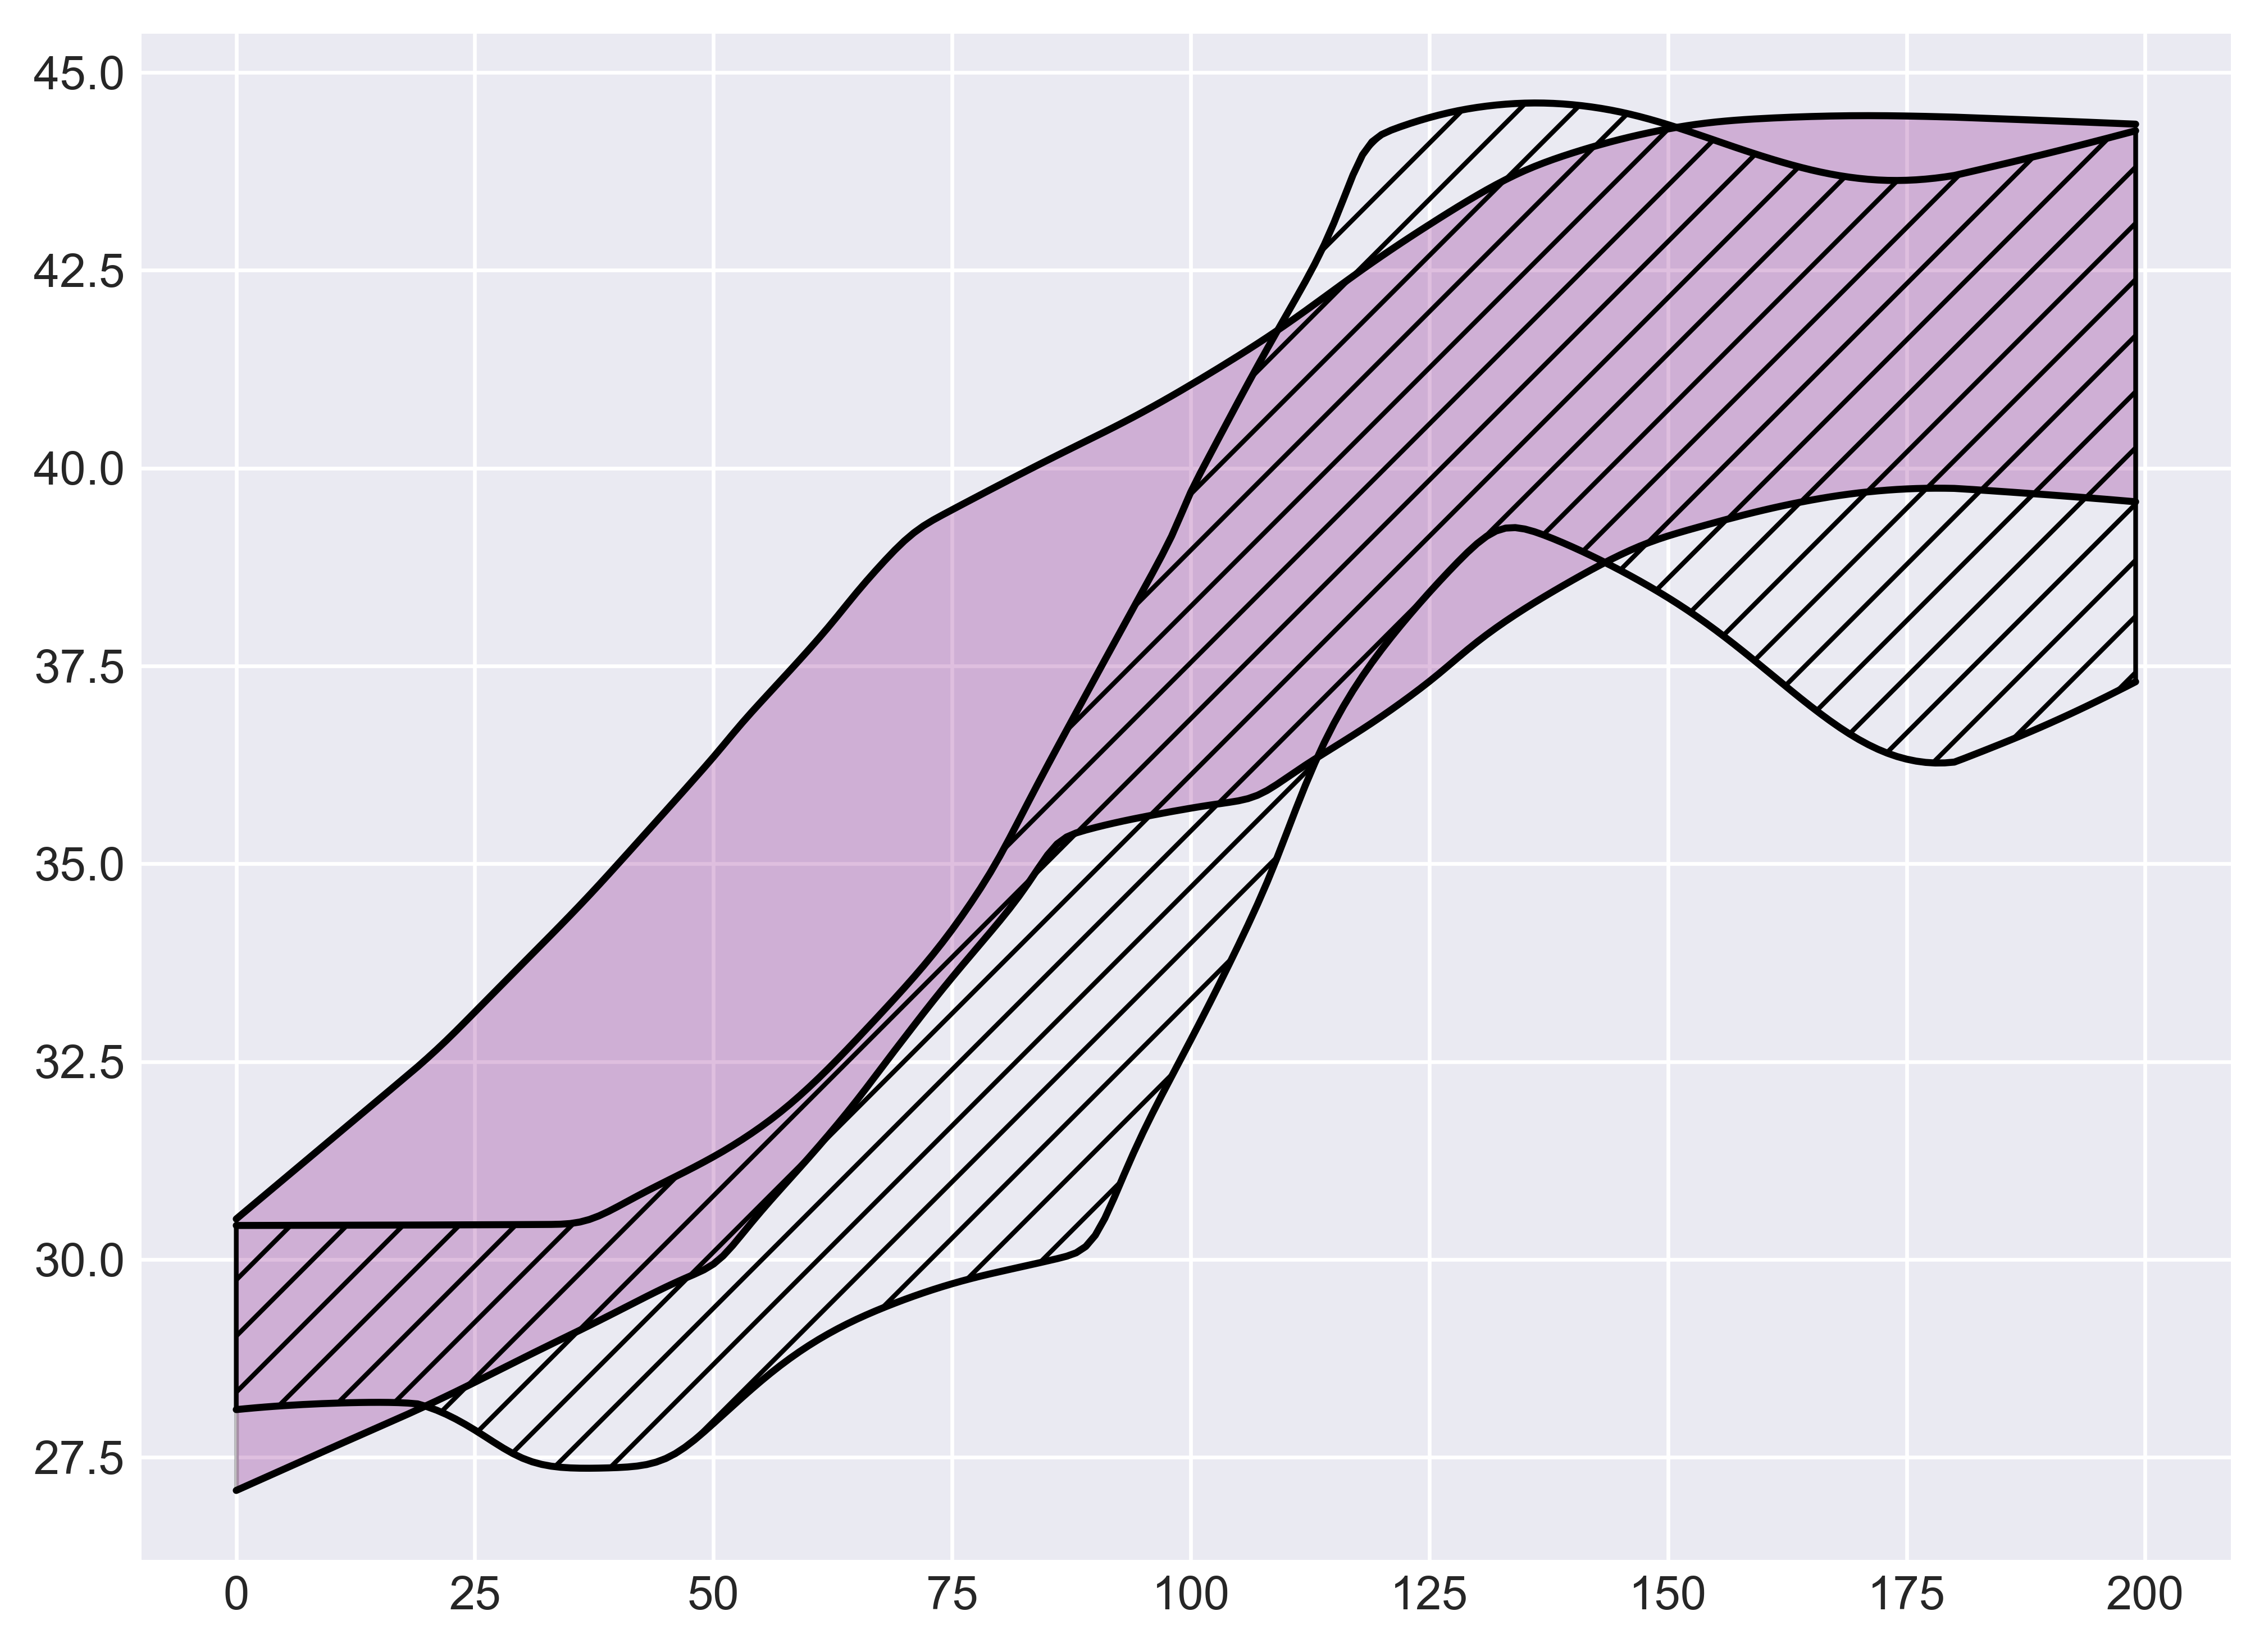

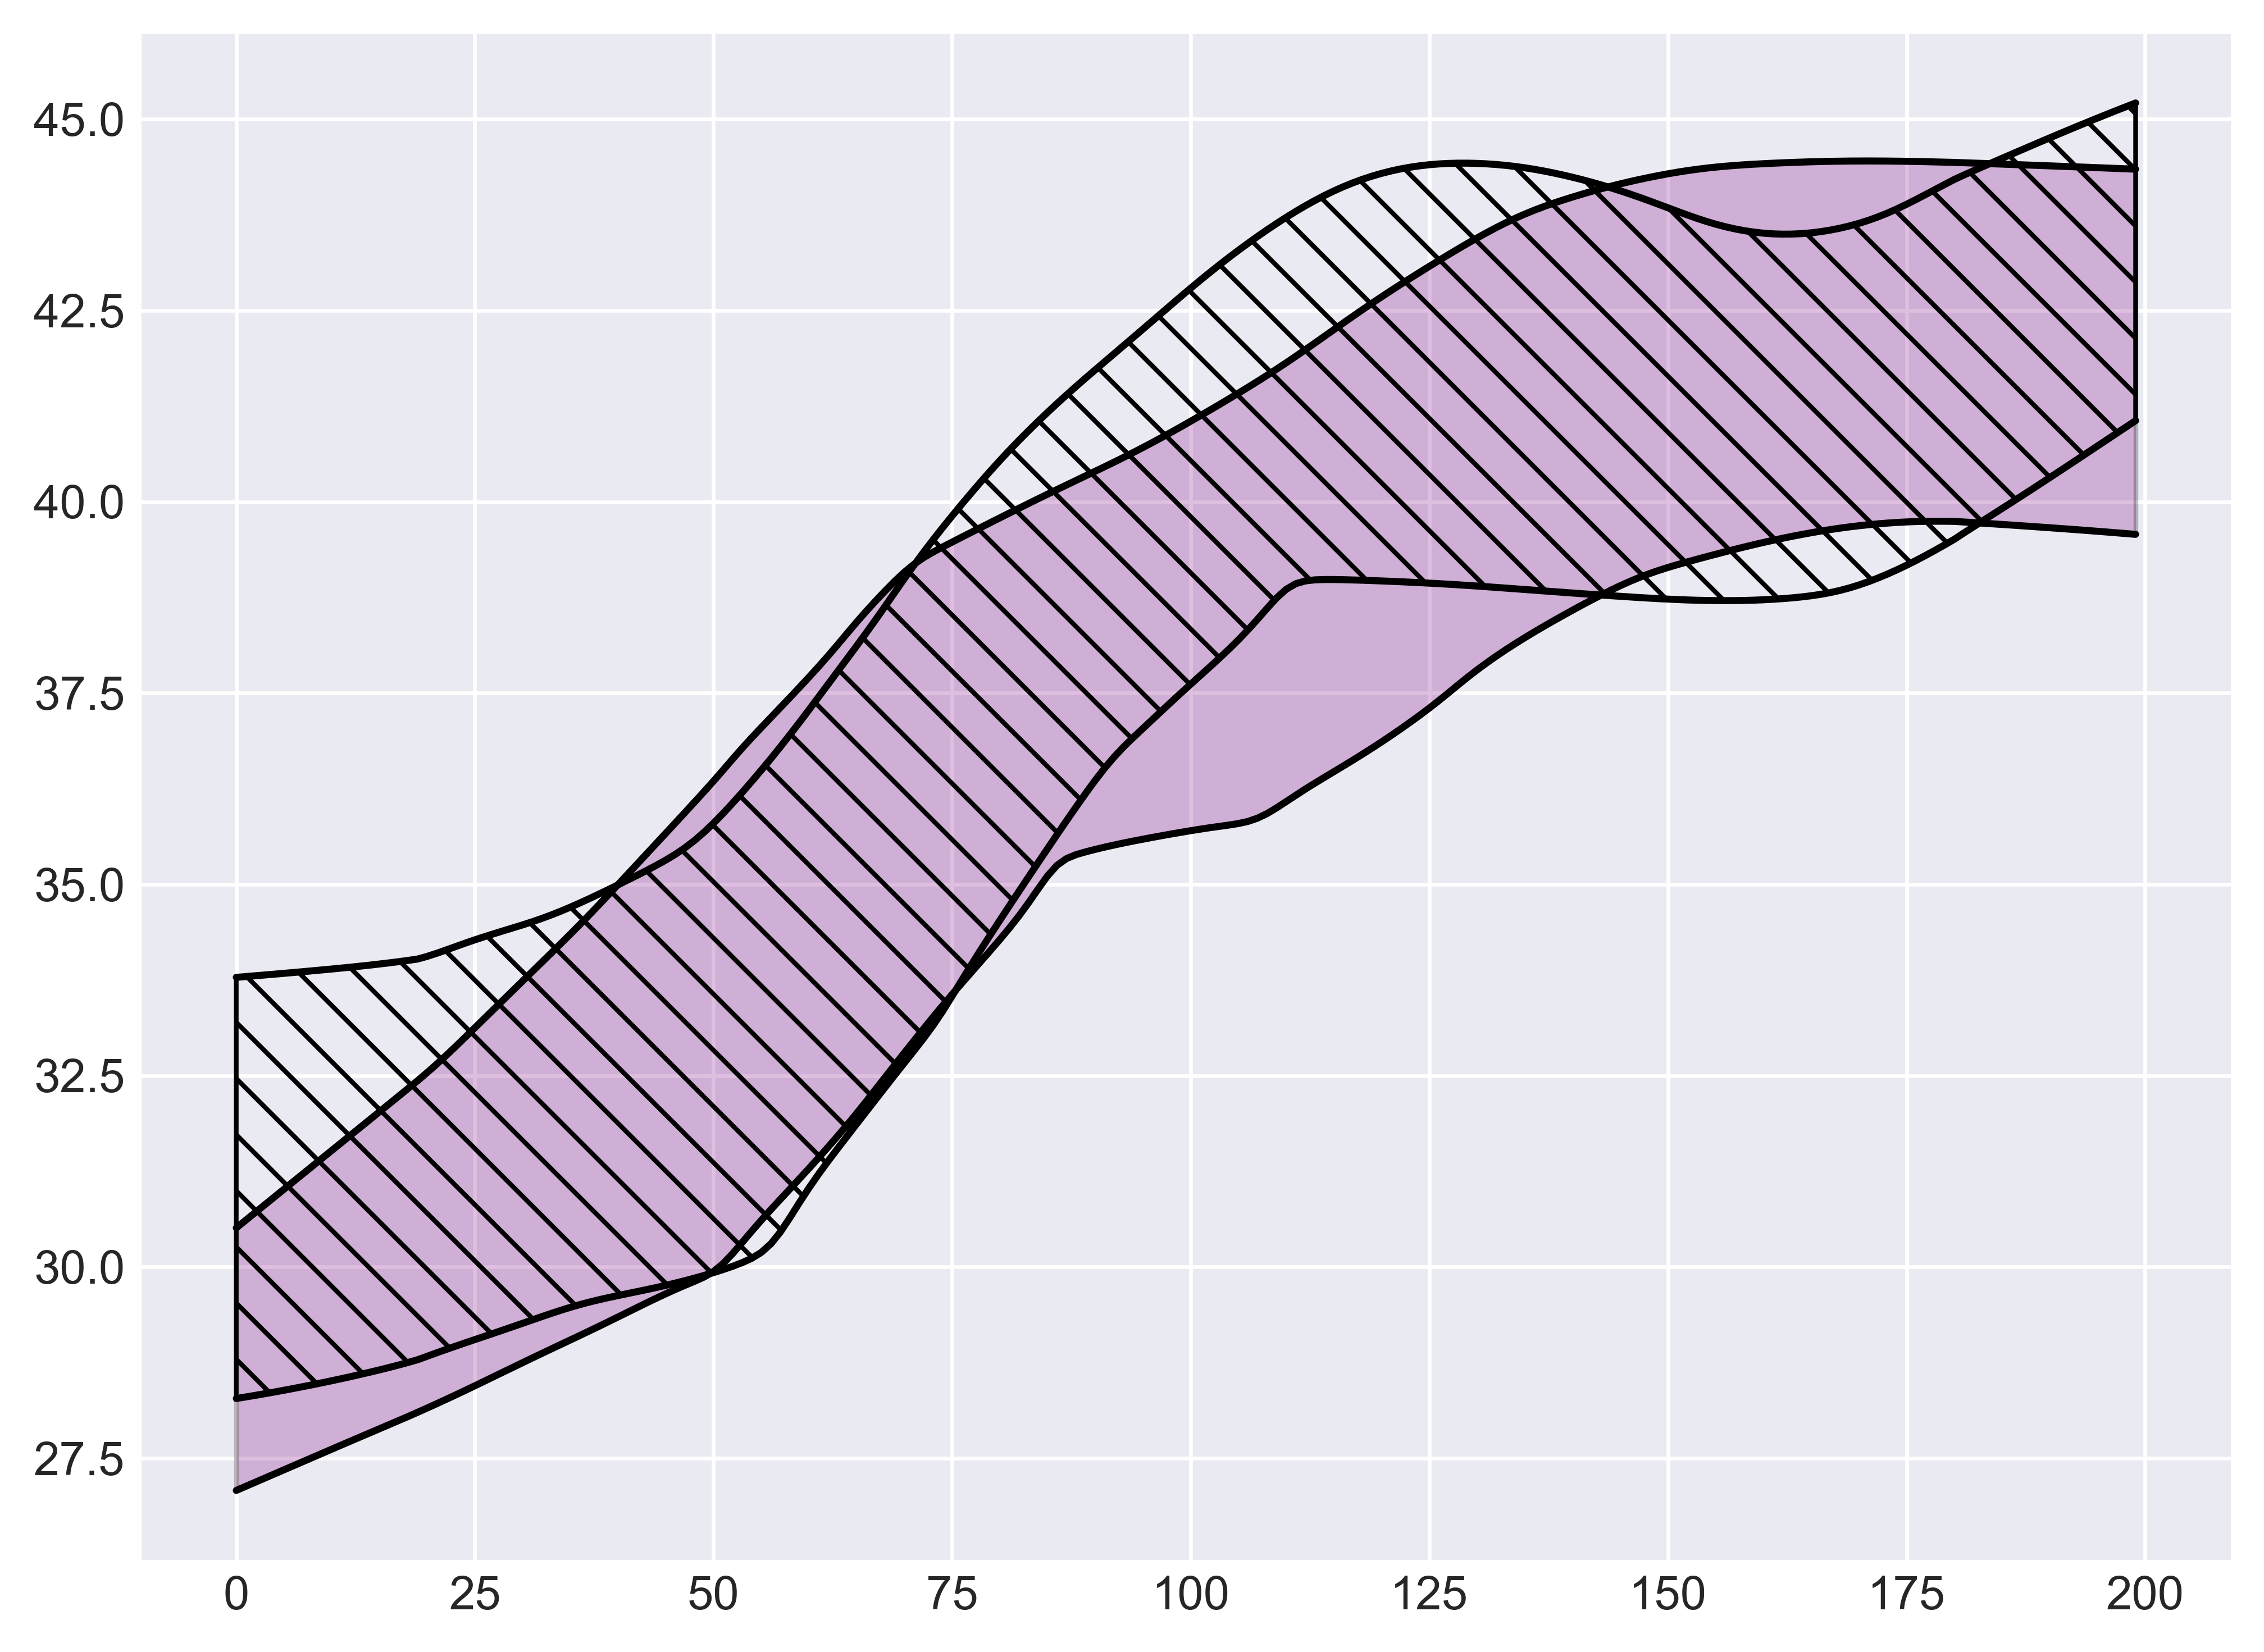

In [43]:
comparecolor = "pinkpurple"

# constants
# mid 50 perc
percentile_threshold_upper = 0.75
percentile_threshold_lower = 0.25
# set window size
window_size = 30
max_days = 200  # capping to spring

# init df
quantile_dat = pd.DataFrame(index=range(365 - window_size), columns=["red_upper", "red_lower", f"{comparecolor}_upper", f"{comparecolor}_lower", "hummers_upper", "hummers_lower", "bombus_upper", "bombus_lower"])

# get quantiles in each window
subdf = dat[(dat.color.isin(['pink','purple'])) & (dat['lon_window'] == "Lon: -96 to -59")]

if len(subdf) > 0:
    for day in range(365 - window_size): # doing all year for now, capping later
        day_range = list(range(day, day + window_size))
        window_df = subdf[subdf['day_of_year'].isin(day_range)]

        if len(window_df) > 0:
            upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
            lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)

            quantile_dat.loc[day, f"{comparecolor}_upper"] = upper_val
            quantile_dat.loc[day, f"{comparecolor}_lower"] = lower_val

# hummingbird quantiles
hummers_subdf = hummingbirds[hummingbirds['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = hummers_subdf[hummers_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "hummers_upper"] = upper_val
        quantile_dat.loc[day, "hummers_lower"] = lower_val

# bumblebee quantiles
bombus_subdf = bumblebees[bumblebees['lon_window'] == "Lon: -96 to -59"]
for day in range(365 - window_size):
    day_range = list(range(day, day + window_size))
    window_df = bombus_subdf[bombus_subdf['day_of_year'].isin(day_range)]
    
    if len(window_df) > 0:
        upper_val = np.quantile(window_df['latitude'], percentile_threshold_upper)
        lower_val = np.quantile(window_df['latitude'], percentile_threshold_lower)
        
        quantile_dat.loc[day, "bombus_upper"] = upper_val
        quantile_dat.loc[day, "bombus_lower"] = lower_val

# numeric columns
quantile_dat = quantile_dat.apply(pd.to_numeric, errors='coerce')

# backfill na vals if present
quantile_dat = quantile_dat.fillna(method='bfill')

# grey background
plt.style.use('seaborn-darkgrid')

# convenience plotting function
def plot_quantile_data(x, y1, y2, fill_color, label, alpha, frac=0.2, hatch=None, edgecolor='black'):
    # smooth slightly to look nice
    smoothed_y1 = lowess(y1, x, frac=frac)[:, 1]
    smoothed_y2 = lowess(y2, x, frac=frac)[:, 1]

    # plot lower and upper bound lines
    plt.plot(x, smoothed_y1, color='black', label=f'{label} lower (smoothed)')
    plt.plot(x, smoothed_y2, color='black', label=f'{label} upper (smoothed)')

    # fill with color and hatch
    plt.fill_between(x, smoothed_y1, smoothed_y2, color=fill_color, alpha=alpha, hatch=hatch, edgecolor=edgecolor)

# finally cap the x range
x = range(min(365 - window_size, max_days))

### vs hummingbirds ###
plt.figure(figsize=(8, 6))

# solid red fill for red flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], 'purple', f'{comparecolor} Flowers', 0.25)

# hatched fill for hummingbirds
plot_quantile_data(x, quantile_dat['hummers_lower'][:max_days], quantile_dat['hummers_upper'][:max_days], fill_color='none', 
                   label='Hummingbirds', alpha=1, hatch='//', edgecolor='black')


# save and show
plt.savefig('../purplehumm.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### vs bumblebees ###
plt.figure(figsize=(8, 6))

# solid white fill for white flowers
plot_quantile_data(x, quantile_dat[f'{comparecolor}_lower'][:max_days], quantile_dat[f'{comparecolor}_upper'][:max_days], 'purple', f'{comparecolor} Flowers', .25)

# hatching for bumblebees, different direction than hummers
plot_quantile_data(x, quantile_dat['bombus_lower'][:max_days], quantile_dat['bombus_upper'][:max_days], fill_color='none', 
                   label='Bumblebees', alpha=1, hatch='\\\\', edgecolor='black')

# save and show
plt.savefig('../purplebombus.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

# Leading edge with hummingbirds

In [35]:
# windows for day_of_year, longitude, and latitude
dat['day_window'] = pd.cut(dat['day_of_year'], 
                           bins=[0, 40, 80, 120, 160, 200, 240, 280, 320, 366],
                           labels=["0-40", "40-80", "80-120", "120-160", "160-200",
                                   "200-240", "240-280", "280-320", "320-365"],
                           include_lowest=True)

dat['lon_window'] = pd.cut(dat['longitude'],
                           bins=[-130, -96, -59],
                           labels=["-130 to -96", "-96 to -59"],
                           include_lowest=True)

dat['lat_window'] = pd.cut(dat['latitude'],
                           bins=[24, 29, 34, 39, 44, 49, 54],
                           labels=["24-29", "29-34", "34-39", "39-44", "44-49", "49-54"],
                           include_lowest=True)

In [36]:
# windows for day_of_year, longitude, and latitude
hummers_subdf['day_window'] = pd.cut(hummers_subdf['day_of_year'], 
                           bins=[0, 40, 80, 120, 160, 200, 240, 280, 320, 366],
                           labels=["0-40", "40-80", "80-120", "120-160", "160-200",
                                   "200-240", "240-280", "280-320", "320-365"],
                           include_lowest=True)

hummers_subdf['lon_window'] = pd.cut(hummers_subdf['longitude'],
                           bins=[-130, -96, -59],
                           labels=["-130 to -96", "-96 to -59"],
                           include_lowest=True)

hummers_subdf['lat_window'] = pd.cut(hummers_subdf['latitude'],
                           bins=[24, 29, 34, 39, 44, 49, 54],
                           labels=["24-29", "29-34", "34-39", "39-44", "44-49", "49-54"],
                           include_lowest=True)

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/4003681648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hummers_subdf['day_window'] = pd.cut(hummers_subdf['day_of_year'],
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/4003681648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hummers_subdf['lon_window'] = pd.cut(hummers_subdf['longitude'],
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_99727/4003681648.py:13: SettingWithCopyWarning: 
A value is tryin

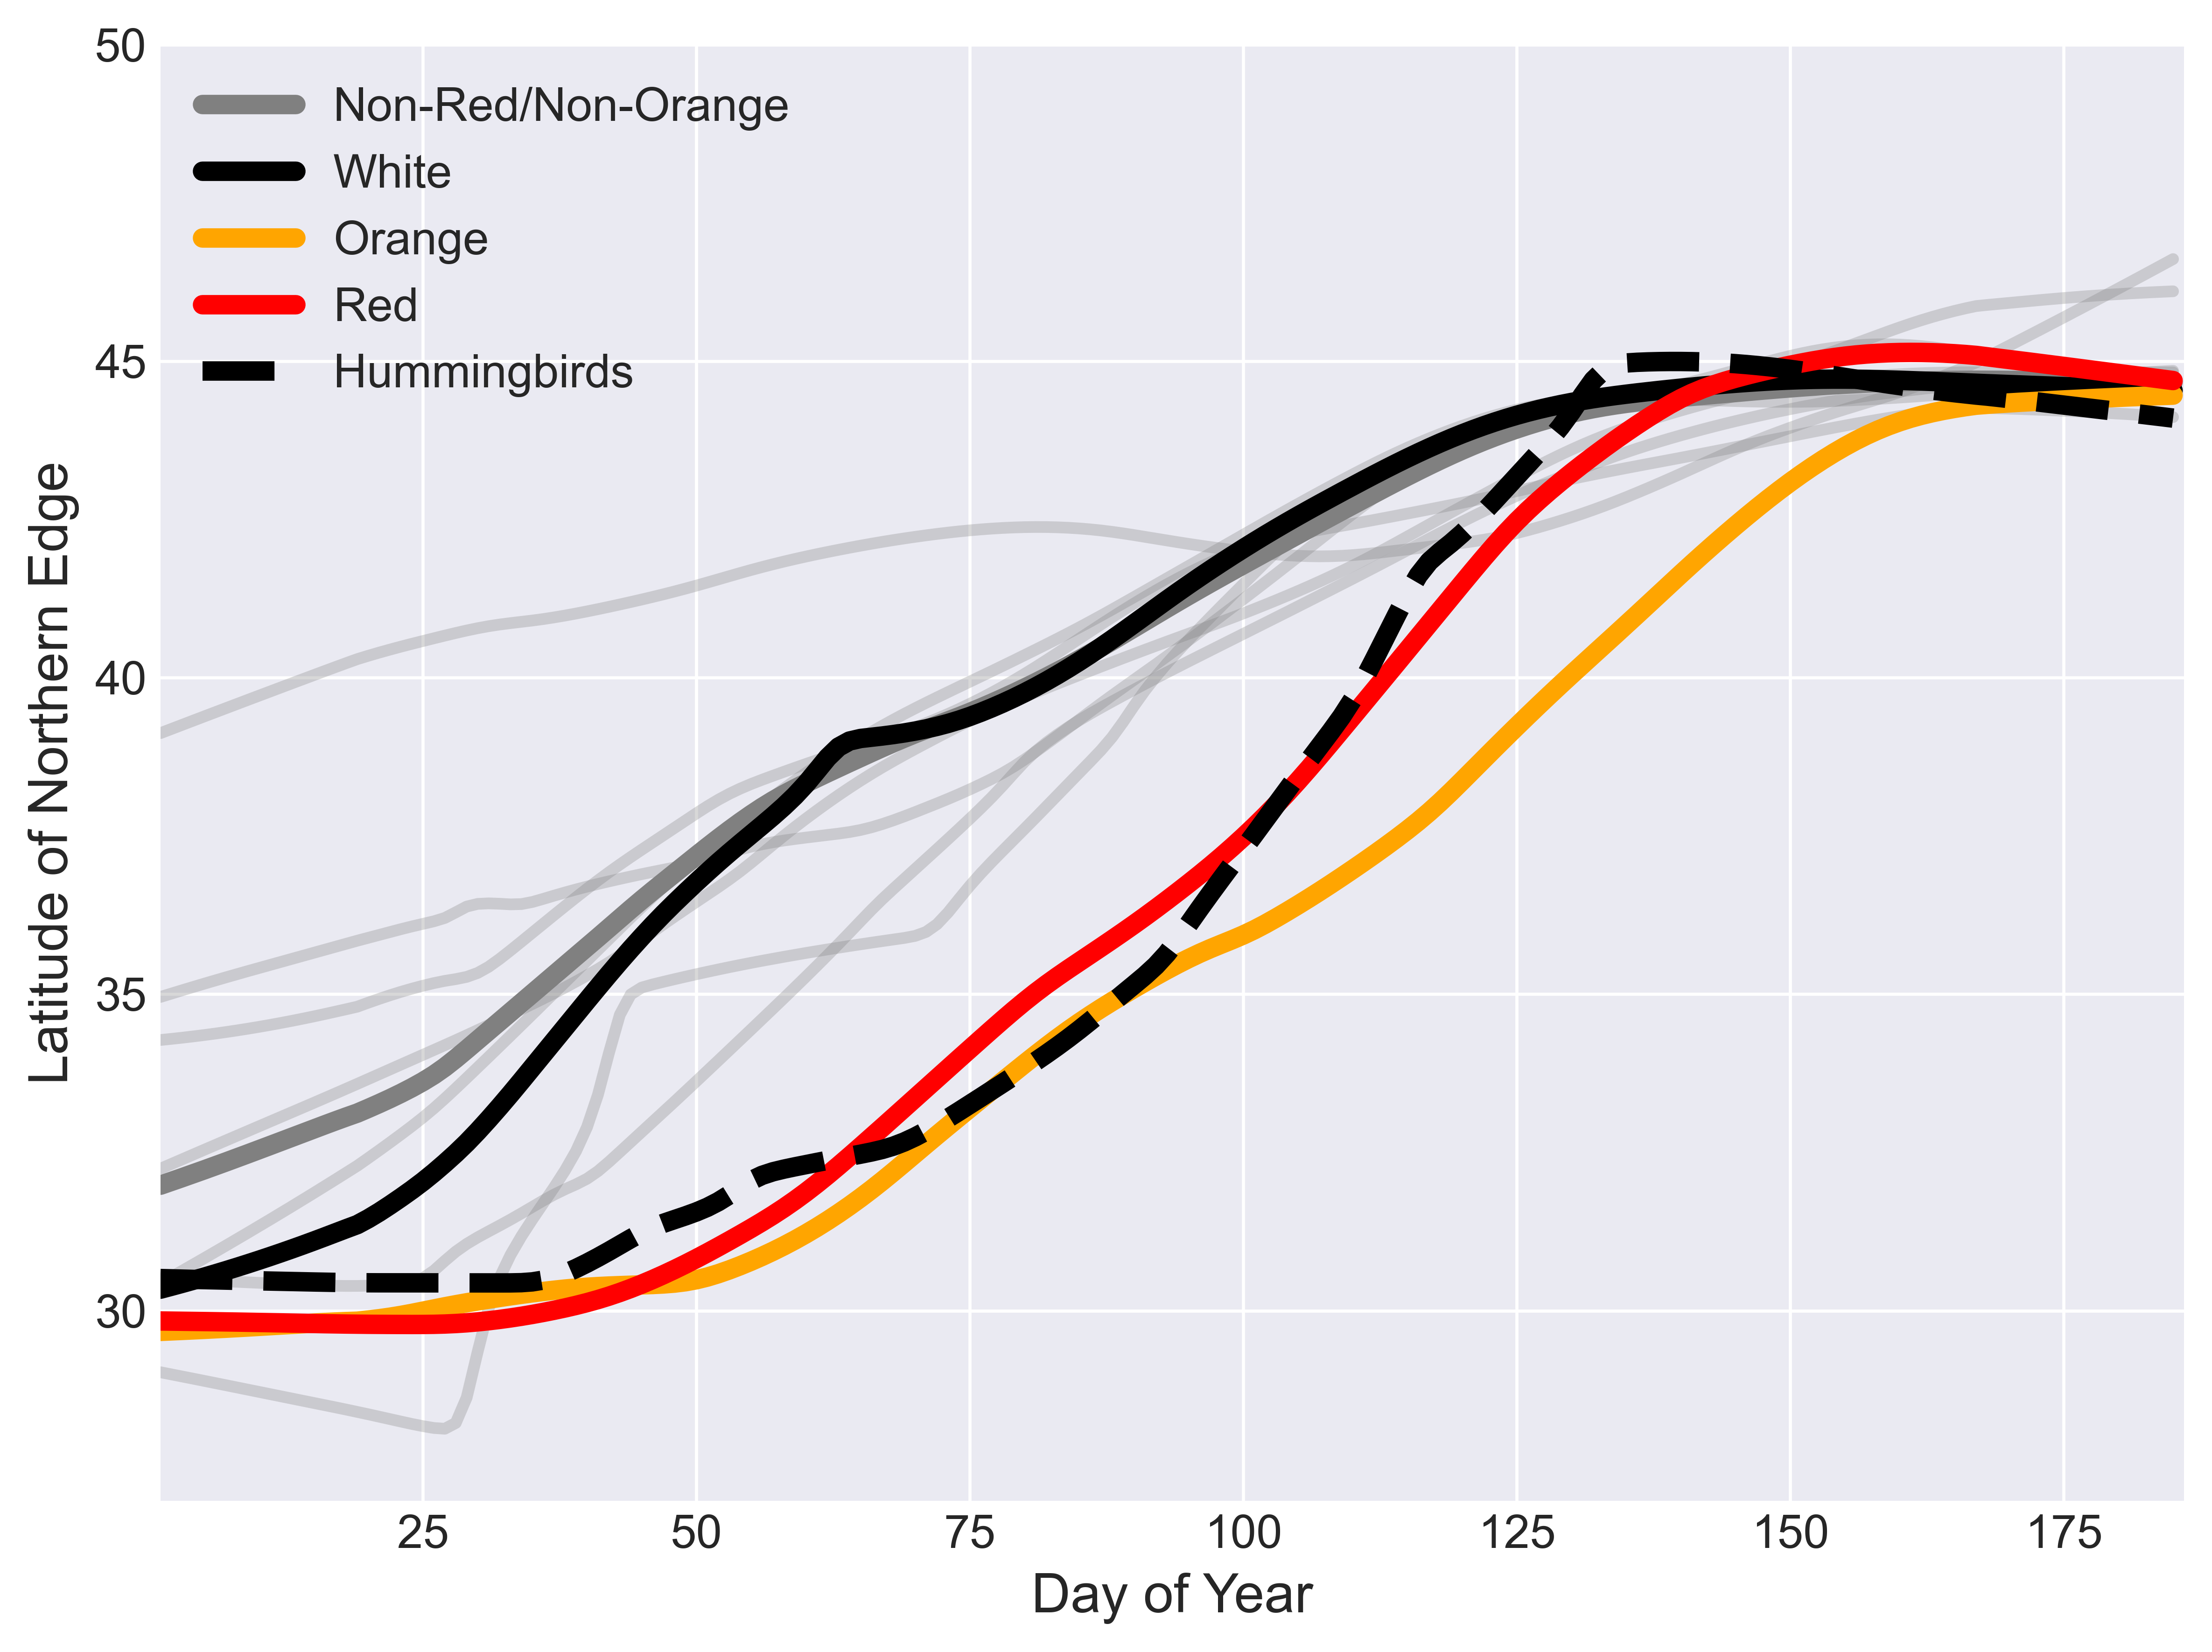

In [37]:
percentile_threshold = 0.8
window_size = 15
max_day = 200 

def calculate_percentiles(dat, color_filter, lon_range, window_size, percentile_threshold, max_day):
    subdf = dat[color_filter]
    subdf = subdf[subdf['lon_window'] == lon_range]
    percentiles = []
    
    for day in range(1, max_day - window_size + 1): 
        day_range = np.arange(day, day + window_size)
        window_df = subdf[subdf['day_of_year'].isin(day_range)]
        if len(window_df) > 0:
            percentile_75 = np.percentile(window_df['latitude'], percentile_threshold * 100)
            percentiles.append(percentile_75)
        else:
            percentiles.append(np.nan)
    return percentiles

def calculate_percentiles_hummers(dat, lon_range, window_size, percentile_threshold, max_day):
    subdf = dat[dat['lon_window'] == lon_range]
    percentiles = []
    
    for day in range(1, max_day - window_size + 1):
        day_range = np.arange(day, day + window_size)
        window_df = subdf[subdf['day_of_year'].isin(day_range)]
        if len(window_df) > 0:
            percentile_75 = np.percentile(window_df['latitude'], percentile_threshold * 100)
            percentiles.append(percentile_75)
        else:
            percentiles.append(np.nan)
    return percentiles

# separate filters for the different categories
red_filter = dat['color'] == 'red'
orange_filter = dat['color'] == 'orange'
white_filter = dat['color'] == 'white'
non_red_orange_filter = (~dat['color'].isin(['red', 'orange']))  # non-red, non-orange, and non-white

# colors to lump together (excluding red, orange, and white)
lumped_colors = ['blue', 'maroon', 'yellow', 'brown', 'purple', 'pink', 'green']

# calc percentiles for each of the three lines
percentiles_red = calculate_percentiles(dat, red_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_orange = calculate_percentiles(dat, orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_white = calculate_percentiles(dat, white_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_non_red_orange = calculate_percentiles(dat, non_red_orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_hummingbirds = calculate_percentiles_hummers(hummers_subdf, "-96 to -59", window_size, percentile_threshold, max_day)

### Plotting the results###
# high res
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(8, 6))
x = np.arange(1, max_day - window_size + 1)

# plot all other non-red, non-orange colors as one thick gray line
lowess_non_red_orange = lowess(np.array(percentiles_non_red_orange), x, frac=0.2)
plt.plot(lowess_non_red_orange[:, 0], lowess_non_red_orange[:, 1], label='Non-Red/Non-Orange', color='grey', linewidth=5)

# plot individual lines for all lumped colors as gray/thin
for color in lumped_colors:
    color_filter = dat['color'] == color
    percentiles_individual = calculate_percentiles(dat, color_filter, "-96 to -59", window_size, percentile_threshold, max_day)
    lowess_individual = lowess(np.array(percentiles_individual), x, frac=0.2)
    plt.plot(lowess_individual[:, 0], lowess_individual[:, 1], color='grey', linewidth=3, alpha=0.3)

# plot white separately
lowess_white = lowess(np.array(percentiles_white), x, frac=0.2)
plt.plot(lowess_white[:, 0], lowess_white[:, 1], label='White', color='black', linewidth=5)

# plot red and orange as separate lines
lowess_orange = lowess(np.array(percentiles_orange), x, frac=0.2)
plt.plot(lowess_orange[:, 0], lowess_orange[:, 1], label='Orange', color='orange', linewidth=5)

lowess_red = lowess(np.array(percentiles_red), x, frac=0.2)
plt.plot(lowess_red[:, 0], lowess_red[:, 1], label='Red', color='red', linewidth=5)

lowess_hum = lowess(np.array(percentiles_hummingbirds), x, frac=0.2)
plt.plot(lowess_hum[:, 0], lowess_hum[:, 1], label='Hummingbirds', color='black', linewidth=5,linestyle='--')

# labels
#plt.title("Northern Edge Latitude by Color", fontsize=16)
plt.xlabel("Day of Year", fontsize=14) 
plt.ylabel("Latitude of Northern Edge", fontsize=14)

# tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=12)
plt.ylim([27, 50])
plt.xlim([1, max_day - window_size + 1])

# save 
plt.savefig('../leading_edge_east_hummingbirds.pdf', bbox_inches='tight', dpi=600, format='pdf')
plt.tight_layout()
plt.show()